# import 

In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
import pandas as pd
import numpy as np
import time
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import datetime
import pickle
import scipy.sparse as ss
import logging
LOG_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(level=logging.INFO, format=LOG_FORMAT)
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['NUMEXPR_MAX_THREADS'] = '32'
# import seaborn as sns

import IPython.display as ipd
import copy
import random
from pandarallel import pandarallel
# Initialization
pandarallel.initialize(progress_bar=True)
# df.parallel_apply(func)
import time
from gensim.models.word2vec import Word2Vec 
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold,KFold

from transformers import *
import torch.nn as nn
import math
from tqdm import tqdm_notebook as tqdm
from transformers.modeling_bert import BertConfig, BertEncoder, BertAttention,\
BertSelfAttention,BertLayer,BertPooler,BertLayerNorm

from gensim.models.word2vec import Word2Vec 
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold,KFold
from scipy.special import softmax

from category_encoders import *
import json

2021-02-07 12:58:33,358 - INFO - PyTorch version 1.1.0 available.


INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/huangweilin/anaconda3/envs/hyr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/huangweilin/anaconda3/envs/hyr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/huangweilin/anaconda3/envs/hyr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/huangweilin/anaconda3/envs/hyr/lib

# Read

In [5]:
logging.info('start read')
df_master_records = pickle.load(open('../data_sortout/df_master_records.pickle', 'rb'))
se_id_install_list = pickle.load(open('../data_sortout/se_id_install_list.pickle', 'rb'))
df_install_behave = pickle.load(open('../data_sortout/df_install_behave_no_date.pickle', 'rb'))
df_behave_time = pickle.load(open('../data_sortout/df_time_cut.pickle', 'rb'))
# df_userlog = pickle.load(open('../data_sortout/df_userlog_sequence_less.pickle', 'rb'))
se_userlog_cross = pickle.load(open('../data_sortout/se_userlog_cross_id.pickle', 'rb'))
df_userlog_time_seq = pickle.load(open('../data_sortout/df_userlog_time_seq.pickle', 'rb'))

# df_app_list_te_sequence = pickle.load(open('../data_sortout/df_app_list_target_encode_sequence.pickle', 'rb'))
# df_app_behave_te_sequence = pickle.load(open('../data_sortout/df_app_behave_target_encode_sequence.pickle', 'rb'))

df_app_list_te_qcut = pickle.load(open('../data_sortout/df_app_list_target_qcut.pickle', 'rb'))
df_app_behave_te_qcut = pickle.load(open('../data_sortout/df_app_behave_target_qcut.pickle', 'rb'))


logging.info('finish read')

2021-01-18 18:22:31,575 - INFO - start read
2021-01-18 18:24:11,705 - INFO - finish read


# 数据划分

In [6]:
split_date = datetime.datetime(2019, 8, 31)
end_date = datetime.datetime(2019, 9, 30)

df_master_records = df_master_records.dropna(axis=0, how='any')
df_train_master = df_master_records.query('loan_date <= @split_date')
df_test_master = df_master_records.query('loan_date > @split_date & loan_date <= @end_date')
all_train_id = list(df_train_master.index)
all_test_id = list(df_test_master.index)
logging.info('all_train_id len :%d, all_test_id: %d' % (len(all_train_id), len(all_test_id)))
df_target = df_master_records[['target_1m30+', 'target_2m30+', 'target_3m30+', 'target_4m30+']]

2021-01-18 18:25:43,823 - INFO - all_train_id len :326082, all_test_id: 75896


In [7]:
max_app_list_id = max(se_id_install_list.apply(max))
max_app_behave_id = max(df_install_behave['pkg_id'].apply(max))
max_uselog_id = max(se_userlog_cross.apply(max))
start_app_list_id = max_app_list_id + 1
start_app_behave_id = max_app_behave_id + 1 
start_uselog_id = max_uselog_id + 1

# Feature

## user info

In [8]:
def get_master_user_discrete(df_master_records):
    
    df_master_records['qcut_amount_bin'] = pd.qcut(df_master_records['amount_bin'], 5)
    df_master_records['new_client'] = df_master_records['loan_sequence'] == 1
    df_master_records['qcut_age'] = pd.qcut(df_master_records['age'], 5, duplicates='drop')
    
    df_master_records['qcut_min_income'] = pd.qcut(df_master_records['min_income'], 6, duplicates='drop')
    df_master_records['qcut_max_income'] = pd.qcut(df_master_records['max_income'].apply(int), 6, duplicates='drop')

#     df_master_records['qcut_loan_sequence'] = pd.qcut(df_master_records['loan_sequence'], 6, duplicates='drop')
#     pne_hot_cols = ['months', 'gender', 'educationid', 'marriagestatusid', 'income', 
#                     'qcut_amount_bin', 'new_client', 'qcut_loan_sequence', 'qcut_age', 'qcut_min_income', 'qcut_max_income']
    pne_hot_cols = ['months', 'gender', 'educationid', 'marriagestatusid', 'income', 
                'qcut_amount_bin', 'qcut_age', 'qcut_min_income', 'qcut_max_income']

    return  pd.get_dummies(df_master_records[pne_hot_cols], columns = pne_hot_cols)
df_user_one_hot = get_master_user_discrete(df_master_records)

In [6]:
df_user_one_hot.shape

(401978, 102)

## word2vec

In [9]:
wv_model_app_list = pickle.load(open('../data_sortout/wv_model_app_list.pickle', 'rb'))
wv_model_app_behave = pickle.load(open('../data_sortout/wv_model_app_behave.pickle', 'rb'))
wv_model_userlog = pickle.load(open('../data_sortout/wv_model_userlog_cross.pickle', 'rb'))

# train

## 调参

In [10]:
from collections import namedtuple

ARG = namedtuple('ARG', [
    'batch_size',
    'epoch',
    'lr',
    'weight_decay',
    'debug',
    'n_embedding',
    'app_install_list_max_length',
    'app_behave_max_length',
    'userlog_max_length',
    'n_eval',
    'dropout_rate',
    'n_worker',
    'use_cuda',
    'n_gpu',
    'device',
    'card_list'
])
 
args = ARG(
    batch_size = 256,
    epoch = 10,
    lr = 0.001,
    weight_decay = 0.0,
    dropout_rate = 0.,
    debug = False,
    n_embedding = 100,
    app_install_list_max_length = 256,
    app_behave_max_length = 256,
    userlog_max_length = 256,
    n_eval = len(all_test_id)+1,
    n_worker = 0,
    use_cuda = True,
    n_gpu = 1,
    card_list = [0, 1],
    device=torch.device("cuda:1"),
#     device=torch.device("cpu")

)

## dataset

In [11]:
install_behave_set = set(df_install_behave.index) & (set(all_train_id) | set(all_test_id))
install_list_set = set(se_id_install_list.index) & (set(all_train_id) | set(all_test_id))
user_info_set = set(df_user_one_hot.index) & (set(all_train_id) | set(all_test_id))
user_log_set = set(se_userlog_cross.index) & (set(all_train_id) | set(all_test_id))

In [12]:
class AppDataset(Data.Dataset):
    def __init__(self, master_ids):
        self.master_ids = list(master_ids)
        
    def __len__(self):
        return len(self.master_ids)
    
    def __getitem__(self,idx):
        return self.master_ids[idx]

x_dict = {
    
    'user_info' : np.zeros((args.batch_size, df_user_one_hot.shape[1])),

    'app_list' : np.zeros((args.batch_size, args.app_install_list_max_length + 1)).astype('int'),
    'app_list_te_qcut' : np.zeros((args.batch_size, args.app_install_list_max_length + 1, 4)).astype('int'),
    'app_list_len' :  np.zeros((args.batch_size,)).astype('int'),
    
    'app_behave' : np.zeros((args.batch_size, args.app_behave_max_length + 1)).astype('int'),
    'app_behave_time_cut' : np.zeros((args.batch_size, args.app_behave_max_length + 1)).astype('int'),
    'app_behave_time_qcut' : np.zeros((args.batch_size, args.app_behave_max_length + 1)).astype('int'),
    
    'app_behave_action' : np.zeros((args.batch_size, args.app_behave_max_length + 1)).astype('int'),
    'app_behave_te_qcut' : np.zeros((args.batch_size, args.app_behave_max_length + 1, 4)).astype('int'),

    'app_behave_len' :  np.zeros((args.batch_size,)).astype('int'),
    
    'userlog' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    'userlog_len' :  np.zeros((args.batch_size,)).astype('int'),
    'userlog_day_qcut' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    'userlog_day_cut' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    'userlog_second_qcut' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    'userlog_second_cut' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    
    'view_mask' : np.zeros((args.batch_size, 4)).astype('int'),
}

def set_first_token():
    x_dict['app_list'][:, 0] = start_app_list_id
    x_dict['app_behave'][:, 0] = start_app_behave_id
    x_dict['userlog'][:, 0] = start_uselog_id

    x_dict['app_list'][:, 0] = 0
    x_dict['app_behave'][:, 0] = 0
    x_dict['userlog'][:, 0] = 0

    x_dict['userlog_day_qcut'][:, 0] = 8
    x_dict['userlog_day_cut'][:, 0] = 8
    x_dict['userlog_second_qcut'][:, 0] = 32
    x_dict['userlog_second_cut'][:, 0] = 32

set_first_token()

def collate_fn(master_ids):
    master_ids = np.array(master_ids)

#     sub_master_id = se_id_install_list.loc[master_ids]
#     df_sub_behave = df_install_behave.loc[master_ids]
#     df_sub_time = df_behave_time.loc[master_ids]
    for i, master_id in enumerate(master_ids):
        if master_id in user_info_set:
            x_dict['user_info'][i] = df_user_one_hot.loc[master_id].values
            x_dict['view_mask'][i][0] = 1
        else:
            x_dict['user_info'][i] = 0
            x_dict['view_mask'][i][0] = 0

        if master_id in install_list_set:
            app_list = se_id_install_list.at[master_id][:args.app_install_list_max_length]
            x_dict['app_list_len'][i] = len(app_list) + 1
            x_dict['app_list'][i][1 : x_dict['app_list_len'][i]] = app_list
            x_dict['app_list'][i][x_dict['app_list_len'][i] :] = 0
            
#             target_encode_data = np.array(list(df_app_list_te_qcut.loc[master_id].values))[:, :args.app_install_list_max_length].T
#             x_dict['app_list_te_qcut'][i][1 : x_dict['app_list_len'][i]] = target_encode_data
            
            x_dict['view_mask'][i][1] = 1
        else:
            x_dict['app_list_len'][i] = 1
            x_dict['app_list'][i][1:] = 0
            x_dict['app_list_te_qcut'][i] = 0
            x_dict['view_mask'][i][1] = 0

        if master_id in install_behave_set:
            app_behave = df_install_behave['pkg_id'].at[master_id][-args.app_behave_max_length:]
            len_app = len(app_behave) + 1
            x_dict['app_behave_len'][i] = len_app
            x_dict['app_behave'][i][1: len_app] = app_behave
            x_dict['app_behave'][i][len_app :] = 0
            
#             target_encode_data = np.array(list(df_app_behave_te_qcut.loc[master_id].values))[:, -args.app_behave_max_length:].T
#             x_dict['app_behave_te_qcut'][i][1 : len_app] = target_encode_data
            
            x_dict['app_behave_time_cut'][i][1:len_app] = df_behave_time['cut_id'].at[master_id][-args.app_behave_max_length:]
            x_dict['app_behave_time_qcut'][i][1:len_app] = df_behave_time['qcut_id'].at[master_id][-args.app_behave_max_length:]
            x_dict['app_behave_action'][i][1:len_app] = df_install_behave['action'].at[master_id][-args.app_behave_max_length:]
            x_dict['view_mask'][i][2] = 1
        else:
            x_dict['app_behave_len'][i] = 1
            x_dict['app_behave'][i][1:] = 0
            x_dict['app_behave_te_qcut'][i] = 0

            x_dict['app_behave_time_cut'][i][1:] = 0
            x_dict['app_behave_time_qcut'][i][1:] = 0
            x_dict['app_behave_action'][i][1:] = 0
            x_dict['view_mask'][i][2] = 0
        
        
        if master_id in user_log_set:
            userlog_list = se_userlog_cross.at[master_id][:args.userlog_max_length]
            len_userlog = len(userlog_list) + 1
            x_dict['userlog_len'][i] = len_userlog
            x_dict['userlog'][i][1 : len_userlog] = userlog_list
            x_dict['userlog'][i][len_userlog :] = 0
            x_dict['userlog_day_qcut'][i][1 : len_userlog] = df_userlog_time_seq['qcut_day_id'].at[master_id][:args.userlog_max_length]
            x_dict['userlog_day_qcut'][i][len_userlog :] = 0
            x_dict['userlog_day_cut'][i][1 : len_userlog] = df_userlog_time_seq['cut_day_id'].at[master_id][:args.userlog_max_length]
            x_dict['userlog_day_cut'][i][len_userlog :] = 0
            x_dict['userlog_second_qcut'][i][1 : len_userlog] = df_userlog_time_seq['qcut_second_id'].at[master_id][:args.userlog_max_length]
            x_dict['userlog_second_qcut'][i][len_userlog :] = 0
            x_dict['userlog_second_cut'][i][1 : len_userlog] = df_userlog_time_seq['cut_second_id'].at[master_id][:args.userlog_max_length]
            x_dict['userlog_second_cut'][i][len_userlog :] = 0

            x_dict['view_mask'][i][3] = 1
        else:
            x_dict['userlog_len'][i] = 1
            x_dict['userlog'][i] = 0
            x_dict['userlog_day_qcut'][i] = 0
            x_dict['userlog_day_cut'][i] = 0
            x_dict['userlog_second_qcut'][i] = 0
            x_dict['userlog_second_cut'][i] = 0

            x_dict['view_mask'][i][3] = 0
    
    
    len_id = master_ids.shape[0]
    x_dict['app_list'][len_id:] = 0
    x_dict['app_behave'][len_id:] = 0
    return {
        
        'user_info' : torch.tensor(x_dict['user_info'][:len_id]).float(),
        
        'app_list' : torch.tensor(x_dict['app_list'][:len_id]).long(),
        'app_list_te_qcut' : torch.tensor(x_dict['app_list_te_qcut'][:len_id]).long(),
        'app_list_len' : torch.tensor(x_dict['app_list_len'][:len_id]).long(),
        
        'app_behave' : torch.tensor(x_dict['app_behave'][:len_id]).long(),
        'app_behave_te_qcut' : torch.tensor(x_dict['app_behave_te_qcut'][:len_id]).long(),
        'app_behave_len' : torch.tensor(x_dict['app_behave_len'][:len_id]).long(),
        
        'app_behave_time_cut' : torch.tensor(x_dict['app_behave_time_cut'][:len_id]).long(),
        'app_behave_time_qcut' : torch.tensor(x_dict['app_behave_time_qcut'][:len_id]).long(),
        'app_behave_action' : torch.tensor(x_dict['app_behave_action'][:len_id]).long(),
        'userlog' : torch.tensor(x_dict['userlog'][:len_id]).long(),
        'userlog_len' : torch.tensor(x_dict['userlog_len'][:len_id]).long(),
        'userlog_day_qcut' : torch.tensor(x_dict['userlog_day_qcut'][:len_id]).long(),
        'userlog_day_cut' : torch.tensor(x_dict['userlog_day_cut'][:len_id]).long(),
        'userlog_second_qcut' : torch.tensor(x_dict['userlog_second_qcut'][:len_id]).long(),
        'userlog_second_cut' : torch.tensor(x_dict['userlog_second_cut'][:len_id]).long(),

        'view_mask' : torch.tensor(x_dict['view_mask'][:len_id]).long(),
        'labels1' : torch.tensor(df_target.loc[master_ids]['target_1m30+'].values).long(),
        'labels2' : torch.tensor(df_target.loc[master_ids]['target_2m30+'].values).long(),
        'labels3' : torch.tensor(df_target.loc[master_ids]['target_3m30+'].values).long(),
        'labels4' : torch.tensor(df_target.loc[master_ids]['target_4m30+'].values).long(),
    }

## model

### embed weight

In [13]:
def get_app_list_wv_weight():
    weight = np.zeros((start_app_list_id+1, 100))
    for i in tqdm(range(1, start_app_list_id+1)):
        weight[i] = wv_model_app_list.wv[str(i)]
    weight_tensor = torch.tensor(weight).float()
    return weight_tensor

def get_app_behave_wv_weight():
    weight = np.zeros((start_app_behave_id+1, 100))
    for i in tqdm(range(1, start_app_behave_id+1)):
        weight[i] = wv_model_app_behave.wv[str(i)]
    weight_tensor = torch.tensor(weight).float()
    return weight_tensor

def get_userlog_wv_weight():
    weight = np.zeros((start_uselog_id+1, 100))
    for i in tqdm(range(1, start_uselog_id+1)):
        weight[i] = wv_model_userlog.wv[str(i)]
    weight_tensor = torch.tensor(weight).float()
    return weight_tensor

app_list_weight = get_app_list_wv_weight()
app_behave_weight = get_app_behave_wv_weight()
userlog_weight = get_userlog_wv_weight()

### sub model

In [14]:
def masked_softmax(X, valid_len):
    if valid_len is None:
        return F.softmax(X,dim=-1)
    else:
        shape=X.shape
        if valid_len.dim()==1:
            valid_len=valid_len.view(-1,1).repeat(1,shape[1])
        mask = (torch.arange(0,X.shape[-1]).repeat(X.shape[0],1).to(args.device) < valid_len).repeat(1, X.shape[1]).view(shape)
        
        X = X.masked_fill_(~mask, -float('inf'))
        return F.softmax(X,dim=-1).view(shape)

def make_mask(X, valid_len):
    if valid_len is None:
        return F.softmax(X,dim=-1)
    else:
        shape=X.shape
        if valid_len.dim()==1:
            valid_len=valid_len.view(-1,1).repeat(1,shape[1])

        mask=(torch.arange(0,X.shape[1]).repeat(X.shape[0],1).to(X.device)<valid_len).byte()
        return mask.unsqueeze(2) 

class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `query`: (`batch_size`, #queries, `d`)
    # `key`: (`batch_size`, #kv_pairs, `d`)
    # `value`: (`batch_size`, #kv_pairs, `dim_v`)
    # `valid_len`: either (`batch_size`, ) or (`batch_size`, xx)
    def forward(self, query, key, value, valid_len=None):
        d = query.shape[-1]
        # Set transpose_b=True to swap the last two dimensions of key
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return torch.bmm(attention_weights, value)
    
class MLPAttention(nn.Module):
    def __init__(self, key_size, query_size, units, dropout=0., **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, units, bias=False)
        self.W_q = nn.Linear(query_size, units, bias=False)
        self.v = nn.Linear(units, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, valid_len):
        query, key = self.W_k(query), self.W_q(key)
        # Expand query to (`batch_size`, #queries, 1, units), and key to
        # (`batch_size`, 1, #kv_pairs, units). Then plus them with broadcast
        features = query.unsqueeze(2) + key.unsqueeze(1)
        scores = self.v(features).squeeze(-1)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return torch.bmm(attention_weights, value)

class LayerNorm(nn.Module):
    def __init__(self,features,eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma=nn.Parameter(torch.ones(features))
        self.beta=nn.Parameter(torch.zeros(features))
        self.eps=eps
    def forward(self,X):
        mean=X.mean(-1,keepdim=True)
        std=X.std(-1,keepdim=True)
        return self.gamma*(X-mean)/(std+self.eps)+self.beta
    
class MLPAttentionPool(nn.Module):
    def __init__(self,key_size,units):
        super().__init__()
        self.proj = nn.Sequential(nn.Linear(key_size,units,bias=False),
                                  nn.Tanh(),
                                  nn.Linear(units,1,bias=False))
        
    def masked_softmax_1d(self, X, valid_len):
        if valid_len is None:
            return F.softmax(X,dim=-1), _
        else:
            shape=X.shape
            if valid_len.dim()==1:
                valid_len=valid_len.view(-1,1).repeat(1,shape[1])

            mask=(torch.arange(0,X.shape[-1]).repeat(X.shape[0],1).to(X.device)<valid_len).byte()
            X = X.masked_fill_(~mask, -float('inf'))
            return F.softmax(X,dim=-1).view(shape), mask

    def forward(self, key, valid_len):
        scores = self.proj(key).squeeze(-1)
        attention_weights, mask = self.masked_softmax_1d(scores,valid_len)
        seq_out = attention_weights.unsqueeze(-1) * key
        return seq_out.sum(1)

class GeLU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1. + torch.tanh(x * 0.7978845608 * (1. + 0.044715 * x * x)))

class Dense(nn.Module):
    def __init__(self, in_feature, out_feature):
        super().__init__()
        hidden = 128
        self.dense = nn.Sequential(
            nn.Linear(in_feature, hidden),
            GeLU(),
            nn.Dropout(args.dropout_rate),
            nn.Linear(hidden, out_feature)
        )
        self.dense.apply(self._init_weights)
        
    def _init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        return self.dense(x)

class UserNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        n_dim = df_user_one_hot.shape[1]
        self.dense_hidden = Dense(n_dim, config.hidden)

        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        
        x = input_dict['user_info'].to(args.device)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        hidden = self.dense_hidden(x)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

class AppListNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = 64
        self.input_size = 100
        self.embeddings = nn.Embedding.from_pretrained(app_list_weight)
        self.layer_norm = LayerNorm(self.input_size)
        
#         self.attention_layer = DotProductAttention(0.)
#         self.attention_layer = MLPAttention(self.input_size, self.input_size, 256)

        self.attention_layer = MLPAttentionPool(self.input_size, config.hidden)
        self.dense_hidden = Dense(self.input_size, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        app_list_ids = input_dict['app_list'].to(args.device)
        app_list_len = input_dict['app_list_len'].to(args.device)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)

        app_list = self.embeddings(app_list_ids)
        app_list = self.layer_norm(app_list)

        x = self.attention_layer(app_list, app_list_len)
        
        hidden = self.dense_hidden(x)        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)

        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

class AppBehaveNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden
        self.embeddings = nn.Embedding.from_pretrained(app_behave_weight)        
        for i in self.embeddings.parameters():
            i.requires_grad=False
        
        self.qcut_time_embeddings = nn.Embedding(64, 16)
        self.cut_time_embeddings = nn.Embedding(64, 16)
#         self.action_embeddings = nn.Embedding(2, 4)

        
        self.layer_norm = LayerNorm(100)
        self.rnn = nn.GRU(16 + 16 + 100,
                          hidden_size = config.hidden,
                          num_layers = 1,
                          dropout = 0,
                          bidirectional = False, 
                          batch_first=True)
        
#         self.attention_layer = DotProductAttention(0.)
#         self.attention_layer = MLPAttention(config.hidden, config.hidden, config.hidden)
        self.attention_layer = MLPAttentionPool(config.hidden, config.hidden)

        self.dense_hidden = Dense(config.hidden, config.hidden)

        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)

    def rnn_forward(self, x, x_lens):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        hidden, _= self.rnn(X)
        hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(hidden,total_length=x.shape[1],batch_first=True)
        return hidden
   
    def forward(self, input_dict):
        
        app_behave_ids = input_dict['app_behave'].to(args.device)
        app_behave_len = input_dict['app_behave_len'].to(args.device)
        app_behave_time_cut = input_dict['app_behave_time_cut'].to(args.device)
        app_behave_time_qcut = input_dict['app_behave_time_qcut'].to(args.device)
#         app_behave_action = input_dict['app_behave_action'].to(args.device)
        
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        app_behave = self.embeddings(app_behave_ids)
#         app_behave = self.layer_norm(app_behave)
        cut_time_embed = self.cut_time_embeddings(app_behave_time_cut)
        qcut_time_embed = self.cut_time_embeddings(app_behave_time_qcut)
#         action_embed = self.action_embeddings(app_behave_action)
        
        seq_data = torch.cat([
            app_behave, 
            cut_time_embed,
            qcut_time_embed,
#             action_embed,
        ], dim = -1)
        
        
        rnn_out = self.rnn_forward(seq_data, app_behave_len)
        
        x = self.attention_layer(rnn_out, app_behave_len)
#         mask = make_mask(x, app_behave_len)
#         x = x.masked_fill_(~mask, 0).sum(1)

        
        hidden = self.dense_hidden(x)
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

class UserlogNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden
        self.embeddings = nn.Embedding.from_pretrained(userlog_weight)        
#         for i in self.embeddings.parameters():
#             i.requires_grad=False
        self.embeddings_day_qcut = nn.Embedding(9, 8)
        self.embeddings_day_cut = nn.Embedding(9, 8)
        self.embeddings_second_qcut = nn.Embedding(33, 16)
        self.embeddings_second_cut = nn.Embedding(33, 16)

        
        self.layer_norm = LayerNorm(100)
        self.rnn = nn.GRU(100 + 8 + 16 + 8 + 16,
                          hidden_size = config.hidden,
                          num_layers = 1,
                          dropout = 0,
                          bidirectional = False, 
                          batch_first=True)
        
#         self.attention_layer = DotProductAttention(0.)
#         self.attention_layer = MLPAttention(config.hidden, config.hidden, config.hidden)
        self.attention_layer = MLPAttentionPool(config.hidden, config.hidden)

        self.dense_hidden = Dense(config.hidden, config.hidden)

        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)

    def rnn_forward(self, x, x_lens):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        hidden, _= self.rnn(X)
        hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(hidden,total_length=x.shape[1],batch_first=True)
        return hidden
   
    def forward(self, input_dict):
        
        userlog_action_id = input_dict['userlog'].to(args.device)
        userlog_len = input_dict['userlog_len'].to(args.device)
        userlog_day_qcut_id = input_dict['userlog_day_qcut'].to(args.device)
        userlog_day_cut_id = input_dict['userlog_day_cut'].to(args.device)
        userlog_second_qcut_id = input_dict['userlog_second_qcut'].to(args.device)
        userlog_second_cut_id = input_dict['userlog_second_cut'].to(args.device)

        
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        userlog_action = self.embeddings(userlog_action_id)
#         app_behave = self.layer_norm(app_behave)
        userlog_day_qcut = self.embeddings_day_qcut(userlog_day_qcut_id)
        userlog_day_cut = self.embeddings_day_cut(userlog_day_cut_id)
        userlog_second_qcut = self.embeddings_second_qcut(userlog_second_qcut_id)
        userlog_second_cut = self.embeddings_second_cut(userlog_second_cut_id)
        hidden = torch.cat([
            userlog_action,
            userlog_day_qcut,
            userlog_day_cut,
            userlog_second_qcut,
            userlog_second_cut], dim = -1)
        
    
        rnn_out = self.rnn_forward(hidden, userlog_len)
        
        x = self.attention_layer(rnn_out, userlog_len)
#         mask = make_mask(x, app_behave_len)
#         x = x.masked_fill_(~mask, 0).sum(1)

        
        hidden = self.dense_hidden(x)
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
         
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

### interactive model

In [15]:
class Alignment(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.temperature = nn.Parameter(torch.tensor(1 / math.sqrt(config.hidden)))
        self.summary = {}

    def _attention(self, a, b):
        return torch.matmul(a, b.transpose(1, 2)) * self.temperature
    
    def forward(self, a, b, mask_a, mask_b):
        attn = self._attention(a, b)
        mask = torch.matmul(mask_a.float(), mask_b.transpose(1, 2).float()).byte()
        attn.masked_fill_(~mask, -1e7)
        attn_a = F.softmax(attn, dim=1)
        attn_b = F.softmax(attn, dim=2)
        feature_b = torch.matmul(attn_a.transpose(1, 2), a)
        feature_a = torch.matmul(attn_b, b)
        return feature_a, feature_b

class MappedAlignment(Alignment):
    def __init__(self, config):
        super().__init__(config)
        self.projection = nn.Sequential(
            nn.Dropout(args.dropout_rate),
            Dense(config.hidden, config.hidden),
        )

    def _attention(self, a, b):
        a = self.projection(a)
        b = self.projection(b)
        return super()._attention(a, b)

class FullFusion(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dropout = args.dropout_rate
        self.fusion1 = Dense(config.hidden * 2, config.hidden)
        self.fusion2 = Dense(config.hidden * 2, config.hidden)
        self.fusion3 = Dense(config.hidden * 2, config.hidden)
        self.fusion = Dense(config.hidden * 3, config.hidden)

    def forward(self, x, align):
        x1 = self.fusion1(torch.cat([x, align], dim=-1))
        x2 = self.fusion2(torch.cat([x, x - align], dim=-1))
        x3 = self.fusion3(torch.cat([x, x * align], dim=-1))
        x = torch.cat([x1, x2, x3], dim=-1)
        x = F.dropout(x, self.dropout, self.training)
        return self.fusion(x)

class AppConcat(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.applist_embeddings = nn.Embedding.from_pretrained(app_list_weight)
        self.appbehave_embeddings = nn.Embedding.from_pretrained(app_behave_weight)
        for i in self.applist_embeddings.parameters():
            i.requires_grad=False
        for i in self.appbehave_embeddings.parameters():
            i.requires_grad=False
        

        self.qcut_time_embeddings = nn.Embedding(64, 16)
        self.cut_time_embeddings = nn.Embedding(64, 16)
        self.action_embeddings = nn.Embedding(2, 4)
        
        self.app_list_qcut_embed_list = nn.ModuleList([nn.Embedding(17, 16) for _ in range(4)])
        self.app_behave_qcut_embed_list = nn.ModuleList([nn.Embedding(17, 16) for _ in range(4)])

        self.app_list_encoder = Dense(100, config.hidden)
#         self.app_list_encoder = Dense(16 * 4, config.hidden)
        self.attention_layer1 = MLPAttentionPool(config.hidden, config.hidden)
        self.attention_layer2 = MLPAttentionPool(config.hidden, config.hidden)


        self.rnn = nn.GRU(16 + 16 + 100,
#         self.rnn = nn.GRU(16 * 4,
                          hidden_size = config.hidden,
                          num_layers = 1,
                          dropout = 0,
                          bidirectional = False, 
                          batch_first=True)        
        
        
        self.dense = Dense(config.hidden * 2, config.hidden)
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def rnn_forward(self, x, x_lens):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        hidden, _= self.rnn(X)
        hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(hidden,total_length=x.shape[1],batch_first=True)
        return hidden
    
    def maxpool(self, x, mask):
        return x.masked_fill_(~mask, -float('inf')).max(dim=1)[0]

    def app_behave_encode(self, input_dict):
        app_behave_ids = input_dict['app_behave'].to(args.device)
        app_behave_len = input_dict['app_behave_len'].to(args.device)
        app_behave_time_cut = input_dict['app_behave_time_cut'].to(args.device)
        app_behave_time_qcut = input_dict['app_behave_time_qcut'].to(args.device)
        app_behave_action = input_dict['app_behave_action'].to(args.device)
   
#         app_behave_target_encode = input_dict['app_behave_target_encode'].to(args.device)
        
        app_behave_target_qcut = input_dict['app_behave_te_qcut'].to(args.device)

#         app_behave_target_qcut_embed1 = self.app_behave_qcut_embed_list[0](app_behave_target_qcut[:, :, 0])
#         app_behave_target_qcut_embed2 = self.app_behave_qcut_embed_list[1](app_behave_target_qcut[:, :, 1])
#         app_behave_target_qcut_embed3 = self.app_behave_qcut_embed_list[2](app_behave_target_qcut[:, :, 2])
#         app_behave_target_qcut_embed4 = self.app_behave_qcut_embed_list[3](app_behave_target_qcut[:, :, 3])

        app_behave = self.appbehave_embeddings(app_behave_ids)
        cut_time_embed = self.cut_time_embeddings(app_behave_time_cut)
        qcut_time_embed = self.cut_time_embeddings(app_behave_time_qcut)
#         action_embed = self.action_embeddings(app_behave_action)
        
        seq_data = torch.cat([
            app_behave, 
            cut_time_embed,
            qcut_time_embed,
#             app_behave_target_qcut_embed1,
#             app_behave_target_qcut_embed2,
#             app_behave_target_qcut_embed3,
#             app_behave_target_qcut_embed4,
#             app_behave_target_encode,
#             action_embed,
        ], dim = -1)
        
        rnn_out = self.rnn_forward(seq_data, app_behave_len)

        return rnn_out, app_behave_len
    
    def app_list_encode(self, input_dict):
        app_list_ids = input_dict['app_list'].to(args.device)
        app_list_len = input_dict['app_list_len'].to(args.device)
        app_list_embed = self.applist_embeddings(app_list_ids)
        
        app_list_target_qcut = input_dict['app_list_te_qcut'].to(args.device)
#         app_list_target_encode = input_dict['app_list_target_encode'].to(args.device)

        app_list_target_qcut_embed1 = self.app_list_qcut_embed_list[0](app_list_target_qcut[:, :, 0])
        app_list_target_qcut_embed2 = self.app_list_qcut_embed_list[1](app_list_target_qcut[:, :, 1])
        app_list_target_qcut_embed3 = self.app_list_qcut_embed_list[2](app_list_target_qcut[:, :, 2])
        app_list_target_qcut_embed4 = self.app_list_qcut_embed_list[3](app_list_target_qcut[:, :, 3])

        seq_data = torch.cat([
            app_list_embed, 
#             app_list_target_encode,
#             app_list_target_qcut_embed1,
#             app_list_target_qcut_embed2,
#             app_list_target_qcut_embed3,
#             app_list_target_qcut_embed4,

        ], dim = -1)
        
        return self.app_list_encoder(seq_data), app_list_len 
    

    def forward(self, input_dict):
        a, a_len = self.app_behave_encode(input_dict)
        b, b_len = self.app_list_encode(input_dict)
#         mask_a = self.make_mask(a, a_len)
#         mask_b = self.make_mask(b, b_len)
                
        a = self.attention_layer1(a, a_len)
        b = self.attention_layer2(b, b_len)
        
        hidden = self.dense(torch.cat([a, b], dim=-1)) 

        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)

        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden
    
class AppInteractiveNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.applist_embeddings = nn.Embedding.from_pretrained(app_list_weight)
        self.appbehave_embeddings = nn.Embedding.from_pretrained(app_behave_weight)
        for i in self.applist_embeddings.parameters():
            i.requires_grad=False
        for i in self.appbehave_embeddings.parameters():
            i.requires_grad=False
        

        self.qcut_time_embeddings = nn.Embedding(64, 16)
        self.cut_time_embeddings = nn.Embedding(64, 16)
        self.action_embeddings = nn.Embedding(2, 4)
        
        self.app_list_qcut_embed_list = nn.ModuleList([nn.Embedding(17, 16) for _ in range(4)])
        self.app_behave_qcut_embed_list = nn.ModuleList([nn.Embedding(17, 16) for _ in range(4)])

        self.app_list_encoder = Dense(100, config.hidden)
#         self.app_list_encoder = Dense(16 * 4, config.hidden)


        self.rnn = nn.GRU(16 + 16 + 100,
#         self.rnn = nn.GRU(16 * 4,
                          hidden_size = config.hidden,
                          num_layers = 1,
                          dropout = 0,
                          bidirectional = False, 
                          batch_first=True)
        
        self.alignment_layer = MappedAlignment(config)
        self.fusion_layer = FullFusion(config)
        
        
        
        self.dense = Dense(config.hidden * 4, config.hidden)
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def rnn_forward(self, x, x_lens):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        hidden, _= self.rnn(X)
        hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(hidden,total_length=x.shape[1],batch_first=True)
        return hidden
    
    def maxpool(self, x, mask):
        return x.masked_fill_(~mask, -float('inf')).max(dim=1)[0]

    def app_behave_encode(self, input_dict):
        app_behave_ids = input_dict['app_behave'].to(args.device)
        app_behave_len = input_dict['app_behave_len'].to(args.device)
        app_behave_time_cut = input_dict['app_behave_time_cut'].to(args.device)
        app_behave_time_qcut = input_dict['app_behave_time_qcut'].to(args.device)
        app_behave_action = input_dict['app_behave_action'].to(args.device)
   
#         app_behave_target_encode = input_dict['app_behave_target_encode'].to(args.device)
        
#         app_behave_target_qcut = input_dict['app_behave_te_qcut'].to(args.device)

#         app_behave_target_qcut_embed1 = self.app_behave_qcut_embed_list[0](app_behave_target_qcut[:, :, 0])
#         app_behave_target_qcut_embed2 = self.app_behave_qcut_embed_list[1](app_behave_target_qcut[:, :, 1])
#         app_behave_target_qcut_embed3 = self.app_behave_qcut_embed_list[2](app_behave_target_qcut[:, :, 2])
#         app_behave_target_qcut_embed4 = self.app_behave_qcut_embed_list[3](app_behave_target_qcut[:, :, 3])

        app_behave = self.appbehave_embeddings(app_behave_ids)
        cut_time_embed = self.cut_time_embeddings(app_behave_time_cut)
        qcut_time_embed = self.cut_time_embeddings(app_behave_time_qcut)
#         action_embed = self.action_embeddings(app_behave_action)
        
        seq_data = torch.cat([
            app_behave, 
            cut_time_embed,
            qcut_time_embed,
#             app_behave_target_qcut_embed1,
#             app_behave_target_qcut_embed2,
#             app_behave_target_qcut_embed3,
#             app_behave_target_qcut_embed4,
#             app_behave_target_encode,
#             action_embed,
        ], dim = -1)
        
        rnn_out = self.rnn_forward(seq_data, app_behave_len)

        return rnn_out, app_behave_len
    
    def app_list_encode(self, input_dict):
        app_list_ids = input_dict['app_list'].to(args.device)
        app_list_len = input_dict['app_list_len'].to(args.device)
        app_list_embed = self.applist_embeddings(app_list_ids)
        
        app_list_target_qcut = input_dict['app_list_te_qcut'].to(args.device)
#         app_list_target_encode = input_dict['app_list_target_encode'].to(args.device)

        app_list_target_qcut_embed1 = self.app_list_qcut_embed_list[0](app_list_target_qcut[:, :, 0])
        app_list_target_qcut_embed2 = self.app_list_qcut_embed_list[1](app_list_target_qcut[:, :, 1])
        app_list_target_qcut_embed3 = self.app_list_qcut_embed_list[2](app_list_target_qcut[:, :, 2])
        app_list_target_qcut_embed4 = self.app_list_qcut_embed_list[3](app_list_target_qcut[:, :, 3])

        seq_data = torch.cat([
            app_list_embed, 
#             app_list_target_encode,
#             app_list_target_qcut_embed1,
#             app_list_target_qcut_embed2,
#             app_list_target_qcut_embed3,
#             app_list_target_qcut_embed4,

        ], dim = -1)
        
        return self.app_list_encoder(seq_data), app_list_len 
    
    def make_mask(self, X, valid_len):
        shape=X.shape
        if valid_len.dim()==1:
            valid_len=valid_len.view(-1,1).repeat(1,shape[1])
        mask=(torch.arange(0,X.shape[1]).repeat(X.shape[0],1).to(X.device)<valid_len).float()
        return mask.unsqueeze(2).byte()

    def forward(self, input_dict):
        a, a_len = self.app_behave_encode(input_dict)
        b, b_len = self.app_list_encode(input_dict)
        mask_a = self.make_mask(a, a_len)
        mask_b = self.make_mask(b, b_len)
        
        align_a, align_b = self.alignment_layer(a, b, mask_a, mask_b)
        a = self.fusion_layer(a, align_a)
        b = self.fusion_layer(b, align_b)
        
        a = self.maxpool(a, mask_a)
        b = self.maxpool(b, mask_b)
        
        hidden = self.dense(torch.cat([a, b, (a - b).abs(), a * b], dim=-1)) #symmetric


        
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)

        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

### multi-view model

In [16]:
class MaskMlpAttention(nn.Module):
    def __init__(self, key_size, units):
        super().__init__()
        self.proj = nn.Sequential(nn.Linear(key_size,units,bias=False),
                                  nn.Tanh(),
                                  nn.Linear(units,1,bias=False))
        
    def forward(self, key, mask):
        scores = self.proj(key).squeeze(-1)
        
        if mask is not None:
            scores = scores.masked_fill_(~mask.byte(), -float('inf'))
            
        softmax_score = F.softmax(scores, dim=-1)
        seq_out = softmax_score.unsqueeze(-1) * key
        return seq_out.sum(1)

class MaskMultiViewEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.user_network = config.user_net
        self.app_list_network = config.app_list_net
        self.app_behave_network = config.app_behave_net
        self.userlog_network = config.userlog_network
        
    def forward(self,input_dict):
        loss_user, y1_user, y2_user, y3_user, y4_user, hidden_user = self.user_network(input_dict)
        loss_list, y1_list, y2_list, y3_list, y4_list, hidden_list = self.app_list_network(input_dict)
        loss_behave, y1_behave, y2_behave, y3_behave, y4_behave, hidden_behave = self.app_behave_network(input_dict)
        loss_userlog, y1_userlog, y2_userlog, y3_userlog, y4_userlog, hidden_userlog = self.userlog_network(input_dict)

        return hidden_user, hidden_list, hidden_behave, hidden_userlog
    
class MaskMultiViewNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoder(config)

        self.attention = MaskMlpAttention(config.hidden, config.hidden)
#         self.attention = MaskMlpAttentionSeperateMap(config.hidden, config.hidden, 3)

        self.dense = Dense(config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        
        hidden_user, hidden_list, hidden_behave, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = input_dict['view_mask'].to(args.device)
        
        multi_view_hidden = torch.cat([hidden_user, hidden_list, hidden_behave, hidden_userlog], dim = 1).view(-1, 4, hidden_user.shape[1])
        hidden = self.attention(multi_view_hidden, view_mask)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)
        hidden = self.dense(hidden)

        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4

        return loss, y1, y2, y3, y4, _

class MaskMultiViewNetworkFillZero(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoder(config)

        self.dense = Dense(config.hidden * 4, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        
        hidden_user, hidden_list, hidden_behave, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = input_dict['view_mask'].to(args.device)
        
        hidden_user = view_mask[:, 0:1].float() * hidden_user
        hidden_list = view_mask[:, 1:2].float() * hidden_list
        hidden_behave = view_mask[:, 2:3].float() * hidden_behave
        hidden_userlog = view_mask[:, 3:4].float() * hidden_userlog

        multi_view_hidden = torch.cat([hidden_user, hidden_list, hidden_behave, hidden_userlog], dim = 1)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)
        hidden = self.dense(multi_view_hidden)

        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4

        return loss, y1, y2, y3, y4, _

class MaskMultiViewNetworkFillZeroIn(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoderAppInteractive(config)

    
        self.dense = Dense(3 * config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def get_3view_mask(self, mask):
        ret = torch.zeros((mask.shape[0], 3))
        ret[:, 0] = mask[:, 0]
        ret[:, 1] = (mask[:, 1] + mask[:, 2]) >= 1
        ret[:, -1] = mask[:, -1]
        return ret

    
    def forward(self, input_dict):
        
        hidden_user, hidden_app, hidden_userlog = self.multiview_encoder(input_dict)
        
        view_mask = self.get_3view_mask(input_dict['view_mask']).to(args.device)
        hidden_user = view_mask[:, 0:1].float() * hidden_user
        hidden_app = view_mask[:, 1:2].float() * hidden_app
        hidden_userlog = view_mask[:, 2:3].float() * hidden_userlog

        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        multi_view_hidden = torch.cat([hidden_user, hidden_app, hidden_userlog], dim = 1)

        
        hidden = self.dense(multi_view_hidden)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4

        return loss, y1, y2, y3, y4, _

class MaskMultiViewNetworkGenerate(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoder(config)

        self.attention_pool1 = MaskMlpAttention(config.hidden, config.hidden)
#         self.attention = MaskMlpAttentionSeperateMap(config.hidden, config.hidden, 3)
        self.attention_pool2 = MaskMlpAttention(config.hidden, config.hidden)

    
        self.decoder_user_info = Dense(config.hidden, config.hidden)
        self.decoder_app_list = Dense(config.hidden, config.hidden)
        self.decoder_app_behave = Dense(config.hidden, config.hidden)
        self.decoder_user_log = Dense(config.hidden, config.hidden)

        self.dense = Dense(config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        
        hidden_user, hidden_list, hidden_behave, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = input_dict['view_mask'].to(args.device)
        
        multi_view_hidden = torch.stack([hidden_user, hidden_list, hidden_behave, hidden_userlog], dim = 1)

        hidden = self.attention_pool1(multi_view_hidden, view_mask)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)

        generate_user = self.decoder_user_info(hidden)
        generate_list = self.decoder_app_list(hidden)
        generate_behave = self.decoder_app_behave(hidden)
        generate_userlog = self.decoder_user_log(hidden)
        
        
        loss_rebuild_user = (hidden_user - generate_user) ** 2 * view_mask[:, 0:1].float()
        loss_rebuild_list = (hidden_list - generate_list) ** 2 * view_mask[:, 1:2].float()
        loss_rebuild_behave = (hidden_behave - generate_behave) ** 2 * view_mask[:, 2:3].float()
        loss_rebuild_userlog = (hidden_userlog - generate_userlog) ** 2 * view_mask[:, 3:4].float()
        loss_rebuild = loss_rebuild_user.mean() + loss_rebuild_list.mean() + loss_rebuild_behave.mean() + loss_rebuild_userlog.mean()
        
        multi_view_hidden_generate = torch.stack([generate_user, generate_list, generate_behave, generate_userlog], dim = 1)
        hidden_generate = self.attention_pool2(multi_view_hidden_generate, None)
        hidden = self.dense(hidden_generate)

        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4 + loss_rebuild

        return loss, y1, y2, y3, y4, _

class MaskMultiViewNetworkGenerateWithResidual(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoder(config)

        self.attention_pool1 = MaskMlpAttention(config.hidden, config.hidden)
#         self.attention = MaskMlpAttentionSeperateMap(config.hidden, config.hidden, 3)
        self.attention_pool2 = MaskMlpAttention(config.hidden, config.hidden)

    
        self.decoder_user_info = Dense(config.hidden, config.hidden)
        self.decoder_app_list = Dense(config.hidden, config.hidden)
        self.decoder_app_behave = Dense(config.hidden, config.hidden)
        self.decoder_user_log = Dense(config.hidden, config.hidden)

        self.dense = Dense(config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
                
    def forward(self, input_dict):
        
        hidden_user, hidden_list, hidden_behave, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = input_dict['view_mask'].to(args.device)
        
        multi_view_hidden = torch.stack([hidden_user, hidden_list, hidden_behave, hidden_userlog], dim = 1)

        hidden = self.attention_pool1(multi_view_hidden, view_mask)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)

        generate_user = self.decoder_user_info(hidden)
        generate_list = self.decoder_app_list(hidden)
        generate_behave = self.decoder_app_behave(hidden)
        generate_userlog = self.decoder_user_log(hidden)
        
        
        loss_rebuild_user = (hidden_user - generate_user) ** 2 * view_mask[:, 0:1].float()
        loss_rebuild_list = (hidden_list - generate_list) ** 2 * view_mask[:, 1:2].float()
        loss_rebuild_behave = (hidden_behave - generate_behave) ** 2 * view_mask[:, 2:3].float()
        loss_rebuild_userlog = (hidden_userlog - generate_userlog) ** 2 * view_mask[:, 3:4].float()
        loss_rebuild = loss_rebuild_user.mean() + loss_rebuild_list.mean() + loss_rebuild_behave.mean() + loss_rebuild_userlog.mean()
        
        multi_view_hidden_generate = torch.stack([generate_user, generate_list, generate_behave, generate_userlog], dim = 1)
        hidden_generate = self.attention_pool2(multi_view_hidden_generate, None)
        
        hidden = hidden + hidden_generate
        hidden = self.dense(hidden)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4 + loss_rebuild

        return loss, y1, y2, y3, y4, _

class MaskMultiViewEncoderAppInteractive(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.user_network = config.user_net
        self.app_network = config.app_net
        self.userlog_network = config.userlog_network
        
    def forward(self,input_dict):
        loss_user, y1_user, y2_user, y3_user, y4_user, hidden_user = self.user_network(input_dict)
        loss_app, y1_app, y2_app, y3_app, y4_app, hidden_app = self.app_network(input_dict)
        loss_userlog, y1_userlog, y2_userlog, y3_userlog, y4_userlog, hidden_userlog = self.userlog_network(input_dict)

        return hidden_user, hidden_app, hidden_userlog

class MaskMultiViewNetworkGenerateWithResidualAppInteractive(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoderAppInteractive(config)

        self.attention_pool1 = MaskMlpAttention(config.hidden, config.hidden)
#         self.attention = MaskMlpAttentionSeperateMap(config.hidden, config.hidden, 3)
        self.attention_pool2 = MaskMlpAttention(config.hidden, config.hidden)
    
        self.decoder_user_info = Dense(config.hidden, config.hidden)
        self.decoder_app = Dense(config.hidden, config.hidden)
        self.decoder_user_log = Dense(config.hidden, config.hidden)

        self.dense = Dense(config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
    
    def get_3view_mask(self, mask):
        ret = torch.zeros((mask.shape[0], 3))
        ret[:, 0] = mask[:, 0]
        ret[:, 1] = (mask[:, 1] + mask[:, 2]) >= 1
        ret[:, -1] = mask[:, -1]
        return ret
    
    def forward(self, input_dict):
        
        hidden_user, hidden_app, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = self.get_3view_mask(input_dict['view_mask']).to(args.device)
        
        multi_view_hidden = torch.stack([hidden_user, hidden_app, hidden_userlog], dim = 1)

        hidden = self.attention_pool1(multi_view_hidden, view_mask)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)

        generate_user = self.decoder_user_info(hidden)
        generate_app = self.decoder_app(hidden)
        generate_userlog = self.decoder_user_log(hidden)
        
        
        loss_rebuild_user = (hidden_user - generate_user) ** 2 * view_mask[:, 0:1].float()
        loss_rebuild_app = (hidden_app - generate_app) ** 2 * view_mask[:, 1:2].float()
        loss_rebuild_userlog = (hidden_userlog - generate_userlog) ** 2 * view_mask[:, 2:3].float()
        loss_rebuild = loss_rebuild_user.mean() + loss_rebuild_app.mean()  + loss_rebuild_userlog.mean()
        
        multi_view_hidden_generate = torch.stack([generate_user, generate_app, generate_userlog], dim = 1)
        hidden_generate = self.attention_pool2(multi_view_hidden_generate, None)
        
        hidden = hidden + hidden_generate
        hidden = self.dense(hidden)

        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4 + loss_rebuild

        return loss, y1, y2, y3, y4, {
            'v_final' : hidden,
            
            'v_user_attribute' : hidden_user,
            'v_app' : hidden_app,
            'v_app_inlog' : hidden_userlog,
    
            'v_g_user_attribute' : generate_user,
            'v_g_app' : generate_app,
            'v_g_app_inlog' : generate_userlog,
        }


## trainer

In [17]:
def eval_data(model, master_ids):
    
    if(len(master_ids) > args.n_eval):
        master_ids = random.sample(master_ids, args.n_eval)

    torch_dataset = AppDataset(master_ids)
    data_loader = Data.DataLoader(
        dataset=torch_dataset,      
        batch_size=args.batch_size,      
        shuffle=False,
        collate_fn=collate_fn,
        num_workers = args.n_worker,
    )
    
    loss_list = []
    y1_list, y2_list, y3_list, y4_list = [], [], [], []
    label1_list, label2_list, label3_list, label4_list = [], [], [], []
    hidden_dict_list = []
#     for step, data in enumerate(tqdm(data_loader)):
    with torch.no_grad():
        for step, data in enumerate(data_loader):
            loss, y1, y2, y3, y4, hidden_dict = model(data)

            loss_list.append(loss.item())
            y1_list.append(y1.cpu().detach().numpy())
            y2_list.append(y2.cpu().detach().numpy())
            y3_list.append(y3.cpu().detach().numpy())
            y4_list.append(y4.cpu().detach().numpy())

            label1_list.append(data['labels1'].cpu().detach().numpy())
            label2_list.append(data['labels2'].cpu().detach().numpy())
            label3_list.append(data['labels3'].cpu().detach().numpy())
            label4_list.append(data['labels4'].cpu().detach().numpy())
            
            hidden_dict_list.append(hidden_dict)
        loss = np.mean(loss_list)
        
    y1_np = np.concatenate(y1_list,  axis = 0)
    y2_np = np.concatenate(y2_list,  axis = 0)
    y3_np = np.concatenate(y3_list,  axis = 0)
    y4_np = np.concatenate(y4_list,  axis = 0)

    labels1_np = np.concatenate(label1_list,  axis = 0)
    labels2_np = np.concatenate(label2_list,  axis = 0)
    labels3_np = np.concatenate(label3_list,  axis = 0)
    labels4_np = np.concatenate(label4_list,  axis = 0)

    auc1 = roc_auc_score(labels1_np, y1_np[:, 1])
    auc2 = roc_auc_score(labels2_np, y2_np[:, 1])
    auc3 = roc_auc_score(labels3_np, y3_np[:, 1])
    auc4 = roc_auc_score(labels4_np, y4_np[:, 1])
    auc_all = [auc1, auc2, auc3, auc4]
    
    new_client = np.array(df_master_records['new_client'].loc[master_ids].values)
    new_client_auc1 = roc_auc_score(labels1_np[new_client], y1_np[:, 1][new_client])
    new_client_auc2 = roc_auc_score(labels2_np[new_client], y2_np[:, 1][new_client])
    new_client_auc3 = roc_auc_score(labels3_np[new_client], y3_np[:, 1][new_client])
    new_client_auc4 = roc_auc_score(labels4_np[new_client], y4_np[:, 1][new_client])
    auc_new_client = [new_client_auc1, new_client_auc2, new_client_auc3, new_client_auc4]

    old_client = ~new_client
    old_client_auc1 = roc_auc_score(labels1_np[old_client], y1_np[:, 1][old_client])
    old_client_auc2 = roc_auc_score(labels2_np[old_client], y2_np[:, 1][old_client])
    old_client_auc3 = roc_auc_score(labels3_np[old_client], y3_np[:, 1][old_client])
    old_client_auc4 = roc_auc_score(labels4_np[old_client], y4_np[:, 1][old_client])
    auc_old_client = [old_client_auc1, old_client_auc2, old_client_auc3, old_client_auc4]

    return {
        'loss' : loss,
        '1m30+' : auc1,
        '2m30+' : auc2,
        '3m30+' : auc3,
        '4m30+' : auc4,
        'new_1m30+' : new_client_auc1,
        'new_2m30+' : new_client_auc2,
        'new_3m30+' : new_client_auc3,
        'new_4m30+' : new_client_auc4,
        'old_1m30+' : old_client_auc1,
        'old_2m30+' : old_client_auc2,
        'old_3m30+' : old_client_auc3,
        'old_4m30+' : old_client_auc4,
    }

def train(train_ids, test_ids, model_class, config, tune_log):
        
    torch_dataset = AppDataset(train_ids)
    data_loader = Data.DataLoader(
        dataset=torch_dataset,      
        batch_size=args.batch_size,      
        shuffle=True,
        collate_fn=collate_fn,
        num_workers = args.n_worker,
    )
    
    model = model_class(config).to(args.device)
#     model = UserNetwork().to(args.device)
#     model = AppBehaveNetwork().to(args.device)
#     model = AppListNetwork().to(args.device)
#     model = MaskMultiViewNetwork(config).to(args.device)
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

    decay = ["app_network"]

    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in decay)], "weight_decay": args.weight_decay},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr = args.lr, weight_decay = args.weight_decay)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(len(train_ids)//(args.batch_size)), num_training_steps=int(len(train_ids) / args.batch_size * args.epoch)
    )

    for epoch in range(args.epoch):
        model.train()
        for step, data in enumerate(tqdm(data_loader)):
            loss, y1, y2, y3, y4, _ = model(data)            
            #backward
            S = time.time()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2)
            optimizer.step()
            scheduler.step()
        
        model.eval()
        train_ret_dict = eval_data(model, train_ids)
        test_ret_dict = eval_data(model, test_ids)
        df_ret = pd.DataFrame([
            train_ret_dict, test_ret_dict
        ], index = ['train', 'test'])
        tune_log.write(epoch)
        tune_log.write_df(df_ret)
        
#         install_behave_test = list(set(install_behave_set) & set(test_ids))
#         install_list_test = list(set(install_list_set) & set(test_ids))
#         user_info_test = list(set(user_info_set) & set(test_ids))
#         user_log_test = list(set(user_log_set) & set(test_ids))
        
#         behave_ret_dict = eval_data(model, install_behave_test)
#         list_ret_dict = eval_data(model, install_list_test)
#         userinfo_ret_dict = eval_data(model, user_info_test)
#         userlog_ret_dict = eval_data(model, user_log_test)

#         df_ret = pd.DataFrame([
#             test_ret_dict, behave_ret_dict, list_ret_dict, userinfo_ret_dict, userlog_ret_dict
#         ], index = ['test', 'behave', 'list', 'user_info', 'user_log'])
        

        logging.info('epoch : %d' % epoch)
        ipd.display(df_ret)
#         torch.save(model, 'model/multiview_net_extend.torch.model_%d' % epoch)

        
    return model

## config

In [18]:
class UserNetConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256

class AppbehaveConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256
        
class AppListConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256
        
class Userlogconfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256

class MultiviewConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256
#         self.app_list_net = torch.load('app_list_net.model.torch')
#         self.app_behave_net =  torch.load('app_list_net.model.torch')
#         self.user_net =  torch.load('user_net.model.torch')
        self.app_list_net = AppListNetwork(AppListConfig())
        self.app_behave_net = AppBehaveNetwork(AppbehaveConfig())
        self.user_net = UserNetwork(UserNetConfig())
        self.userlog_network = UserlogNetwork(Userlogconfig())

class MultiviewAppInteractiveConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256
#         self.app_list_net = torch.load('app_list_net.model.torch')
#         self.app_behave_net =  torch.load('app_list_net.model.torch')
#         self.user_net =  torch.load('user_net.model.torch')
        self.app_net = AppInteractiveNetwork(AppListConfig())
        self.user_net = UserNetwork(UserNetConfig())
        self.userlog_network = UserlogNetwork(Userlogconfig())

## model-train

In [19]:
class TuneLog():
    def __init__(self, model_name):
        time_str = time.strftime("%mm_%dd_%Hh_%Mm_%Ss")
        self.file_path = 'log/' + model_name + '_' + time_str + '_log'
        self.file = open(self.file_path, 'w+')
        self.file.write(model_name + '\n')
        arg_dict = args._asdict()
        arg_dict['device'] = str(arg_dict['device'])
        self.file.write(json.dumps(arg_dict, indent = 4) + '\n')
        
    def write(self, epoch, loss=None, df_ret=None):
        self.file.write('%s\nepoch:%d\n' % (time.strftime("%Y-%m-%d %H:%M:%S"), epoch))
#         self.file.write(str(df_ret))
        self.file.write('\n')
    
    def write_df(self, df_ret):
        self.file.write(str(df_ret))
        self.file.write('\n')
    
    def close(self):
        self.file.close()

In [28]:
install_behave_set = set(df_install_behave.index) & (set(all_train_id) | set(all_test_id))
install_list_set = set(se_id_install_list.index) & (set(all_train_id) | set(all_test_id))
user_info_set = set(df_user_one_hot.index) & (set(all_train_id) | set(all_test_id))
user_log_set = set(se_userlog_cross.index) & (set(all_train_id) | set(all_test_id))

In [29]:
mp_name_set_origin = {
    'install_behave_set' : install_behave_set.copy(),
    'install_list_set' : install_list_set.copy(),
    'user_info_set' : user_info_set.copy(),
    'user_log_set' : user_log_set.copy()
}

In [30]:
mp_name_set = {
    'install_behave_set' : install_behave_set,
    'install_list_set' : install_list_set,
    'user_info_set' : user_info_set,
    'user_log_set' : user_log_set
}

## App List 和App behaviors同时缺失

In [31]:
max_rate = len(mp_name_set['install_behave_set'] & mp_name_set['install_list_set']) / len(user_info_set)
rates = list(range(5, int(max_rate*100), 5))
rates.append(max_rate*100)
for rate in rates:
    print(rate)
    n_used = int(len(user_info_set) * rate/100.)
    new_items = random.sample(list(mp_name_set['install_behave_set'] & mp_name_set['install_list_set']), n_used)
    old_items = list(mp_name_set['install_behave_set'] & mp_name_set['install_list_set'])
    for item in old_items:
        mp_name_set['install_behave_set'].remove(item)
        mp_name_set['install_list_set'].remove(item)

    for item in new_items:
        mp_name_set['install_behave_set'].add(item)
        mp_name_set['install_list_set'].add(item)
        
    tune_log = TuneLog('install_list_behave_%f' % rate)

    multiview_net = train(all_train_id, all_test_id, 
                          MaskMultiViewNetworkGenerateWithResidualAppInteractive, 
                          MultiviewAppInteractiveConfig(), tune_log)
    tune_log.close()

    for item in mp_name_set_origin['install_behave_set']:
        mp_name_set['install_behave_set'].add(item)

    for item in mp_name_set_origin['install_list_set']:
        mp_name_set['install_list_set'].add(item)
        
    print(rate / 100., n_used)


5


2021-01-19 22:37:22,351 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.142166,0.699994,0.698618,0.669043,0.661394,0.673399,0.686820,0.663416,0.655825,0.729991,0.727624,0.676094,0.661304
test,1.095709,0.687795,0.696648,0.659653,0.655384,0.662117,0.686716,0.658250,0.652906,0.735876,0.713176,0.661145,0.655929


2021-01-19 22:58:48,564 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.118679,0.713293,0.716631,0.688683,0.677613,0.678637,0.693808,0.669901,0.660626,0.756404,0.751658,0.704865,0.686526
test,1.076060,0.692569,0.703418,0.670087,0.662898,0.671022,0.692048,0.664395,0.655518,0.749757,0.730009,0.681570,0.672924


2021-01-19 23:20:20,736 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.104301,0.733429,0.732215,0.703593,0.692067,0.677595,0.691218,0.665435,0.659219,0.749937,0.756783,0.708320,0.690957
test,1.068519,0.704356,0.715066,0.680415,0.670635,0.660059,0.689912,0.660410,0.652386,0.740472,0.727515,0.678619,0.668874


2021-01-19 23:41:52,522 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.077530,0.747948,0.754147,0.727945,0.713495,0.708391,0.725108,0.700138,0.691430,0.800753,0.800652,0.757949,0.730190
test,1.059299,0.721193,0.726184,0.691605,0.679081,0.693966,0.711090,0.685086,0.674503,0.772941,0.750737,0.698522,0.681267


2021-01-20 00:03:30,271 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.043999,0.776460,0.777838,0.758472,0.743332,0.734013,0.748461,0.725959,0.713534,0.838501,0.832304,0.799344,0.775511
test,1.080058,0.716694,0.719910,0.683699,0.666480,0.692568,0.706965,0.679200,0.664918,0.770358,0.745650,0.693232,0.672796


2021-01-20 00:25:02,195 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.988368,0.814598,0.814702,0.799788,0.786638,0.765439,0.782920,0.761600,0.750812,0.864515,0.854948,0.832710,0.811849
test,1.078446,0.731549,0.730461,0.694227,0.676957,0.692419,0.703406,0.674002,0.659962,0.769275,0.750278,0.698235,0.677596


2021-01-20 00:46:31,491 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.918713,0.839748,0.845197,0.830629,0.816999,0.789487,0.806315,0.785550,0.772118,0.885299,0.887142,0.866752,0.845703
test,1.127849,0.733443,0.728788,0.695113,0.678845,0.689668,0.697194,0.671062,0.658690,0.767413,0.744373,0.695003,0.672717


2021-01-20 01:08:03,698 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.855470,0.860842,0.86942,0.861171,0.847165,0.813180,0.836427,0.823651,0.807672,0.912888,0.909355,0.895678,0.875865
test,1.129508,0.739912,0.73362,0.700602,0.683001,0.699765,0.701766,0.675579,0.662279,0.783674,0.756113,0.709020,0.683650


2021-01-20 01:29:35,627 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.787999,0.886507,0.890274,0.882943,0.867650,0.834540,0.855242,0.842295,0.828080,0.923481,0.915820,0.907539,0.886017
test,1.238013,0.735497,0.726200,0.694572,0.680004,0.685491,0.687428,0.662068,0.652832,0.771580,0.743396,0.698713,0.678132


2021-01-20 01:51:08,476 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.757623,0.891045,0.898815,0.891692,0.875411,0.843175,0.862891,0.851160,0.834682,0.930710,0.929927,0.919868,0.898172
test,1.295401,0.733458,0.722556,0.691586,0.676559,0.685973,0.683886,0.657839,0.648048,0.766452,0.740284,0.697695,0.676253


0.05 20098
10


2021-01-20 02:12:57,498 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.135250,0.697240,0.702157,0.673014,0.665129,0.656035,0.668504,0.645032,0.637403,0.733220,0.733468,0.681517,0.667021
test,1.095074,0.688088,0.697669,0.662173,0.656937,0.653359,0.676102,0.647798,0.642687,0.740814,0.714758,0.662814,0.657100


2021-01-20 02:34:44,798 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.117358,0.719705,0.718610,0.692087,0.683393,0.674207,0.687001,0.660175,0.654164,0.736238,0.738188,0.696038,0.682618
test,1.085349,0.689529,0.695954,0.662776,0.658210,0.656493,0.675483,0.646743,0.640981,0.732334,0.712063,0.663626,0.660541


2021-01-20 02:56:33,214 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.096238,0.740350,0.737484,0.710302,0.699890,0.696314,0.707479,0.687943,0.678838,0.787731,0.762772,0.716002,0.701851
test,1.078216,0.711061,0.717809,0.681759,0.672958,0.677996,0.696935,0.669343,0.662421,0.758012,0.736032,0.682327,0.672800


2021-01-20 03:18:21,197 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.073169,0.742585,0.751059,0.727330,0.714168,0.694983,0.716819,0.698814,0.689870,0.781615,0.787594,0.747015,0.724308
test,1.087674,0.712825,0.720230,0.684768,0.673605,0.680154,0.700805,0.675130,0.666201,0.744781,0.737208,0.685623,0.672925


2021-01-20 03:40:01,430 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.041566,0.778863,0.780844,0.760360,0.746477,0.738406,0.747120,0.726022,0.715568,0.822570,0.823337,0.793635,0.768816
test,1.069333,0.724006,0.726185,0.689273,0.676014,0.693740,0.705941,0.677329,0.666009,0.770117,0.747376,0.693916,0.677435


2021-01-20 04:01:41,491 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.990003,0.802970,0.809631,0.794949,0.779124,0.751272,0.770216,0.753233,0.737672,0.844612,0.849313,0.825484,0.803307
test,1.123362,0.723724,0.723224,0.686001,0.668728,0.684393,0.695148,0.666239,0.651984,0.762922,0.742464,0.688525,0.668731


2021-01-20 04:23:25,985 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.926490,0.833078,0.836672,0.825614,0.811279,0.779629,0.792783,0.777198,0.765458,0.881544,0.877117,0.860507,0.836071
test,1.111935,0.729860,0.728431,0.694251,0.676342,0.689786,0.697823,0.670201,0.656200,0.769610,0.748827,0.699218,0.677044


2021-01-20 04:45:15,043 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.861563,0.862923,0.865962,0.856857,0.840604,0.809673,0.828122,0.815495,0.798866,0.909039,0.901251,0.889049,0.866470
test,1.157599,0.731949,0.727412,0.693795,0.673038,0.686421,0.692855,0.665930,0.651318,0.766773,0.747826,0.701277,0.676177


2021-01-20 05:07:01,324 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.795209,0.881658,0.887538,0.877987,0.860897,0.836813,0.855842,0.841424,0.822569,0.924441,0.919228,0.908983,0.885387
test,1.227245,0.732757,0.728366,0.696121,0.677577,0.688350,0.692918,0.665932,0.653316,0.768085,0.748594,0.703428,0.678286


2021-01-20 05:28:42,149 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.771779,0.888525,0.895836,0.886607,0.871486,0.842317,0.866078,0.851395,0.835329,0.922372,0.920653,0.910379,0.890487
test,1.285861,0.729430,0.723967,0.692527,0.675286,0.681231,0.684802,0.658567,0.648294,0.766456,0.744278,0.700236,0.676163


0.1 40197
15


2021-01-20 05:50:46,225 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.145764,0.702882,0.705988,0.678904,0.670261,0.657885,0.675347,0.655791,0.645471,0.726325,0.733290,0.688624,0.671334
test,1.094957,0.686599,0.694260,0.658915,0.653770,0.650127,0.673329,0.647946,0.642277,0.723800,0.707611,0.655976,0.648327


2021-01-20 06:12:51,870 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.114825,0.720065,0.724615,0.697562,0.684500,0.686653,0.705515,0.685919,0.673199,0.764596,0.758007,0.712497,0.689555
test,1.077085,0.700220,0.706760,0.670329,0.664627,0.674345,0.692834,0.664485,0.657016,0.745241,0.725523,0.674184,0.665352


2021-01-20 06:34:57,398 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.098405,0.737274,0.742227,0.712604,0.701192,0.696285,0.713022,0.684832,0.681365,0.785499,0.781565,0.736592,0.713927
test,1.063781,0.709267,0.718204,0.684040,0.675919,0.683091,0.703741,0.676596,0.671377,0.745942,0.735445,0.686107,0.676452


2021-01-20 06:57:08,684 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.061012,0.754134,0.754471,0.730324,0.721574,0.711048,0.723036,0.702474,0.697382,0.792537,0.791112,0.748887,0.734811
test,1.070397,0.715981,0.720284,0.685556,0.675456,0.686006,0.701697,0.676424,0.668810,0.753139,0.737548,0.685510,0.673611


2021-01-20 07:19:14,682 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.042674,0.782237,0.780715,0.764309,0.748549,0.727815,0.741268,0.720635,0.707828,0.802743,0.816560,0.788997,0.766658
test,1.063605,0.720832,0.723072,0.689894,0.673577,0.681256,0.698501,0.671115,0.659440,0.759104,0.741767,0.690509,0.669546


2021-01-20 07:41:16,963 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.989110,0.801179,0.807336,0.792146,0.777621,0.749723,0.769633,0.753161,0.737900,0.854259,0.850443,0.824388,0.800081
test,1.084021,0.732520,0.730054,0.695292,0.678769,0.695157,0.703053,0.676689,0.663673,0.778094,0.751785,0.699439,0.675477


2021-01-20 08:03:19,268 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.931360,0.836524,0.838973,0.826450,0.811678,0.789084,0.801378,0.786418,0.769365,0.887393,0.880178,0.859165,0.836387
test,1.131475,0.739460,0.734093,0.700008,0.682907,0.699244,0.704775,0.677684,0.664985,0.778993,0.750893,0.701369,0.676246


2021-01-20 08:25:22,541 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.862984,0.856604,0.862123,0.854280,0.837819,0.803032,0.818089,0.807844,0.790701,0.906229,0.903940,0.889306,0.863685
test,1.171238,0.738160,0.729791,0.698247,0.680935,0.693888,0.696858,0.670702,0.658248,0.773631,0.745471,0.701445,0.675712


2021-01-20 08:47:27,457 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.818402,0.876511,0.878959,0.871440,0.855629,0.829674,0.840934,0.829016,0.812327,0.923941,0.917784,0.905662,0.879554
test,1.234945,0.735577,0.725828,0.693982,0.676240,0.690756,0.690764,0.664215,0.651333,0.774105,0.743525,0.699677,0.673700


2021-01-20 09:09:28,840 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.778932,0.885082,0.890244,0.884124,0.866584,0.834112,0.849921,0.841765,0.820725,0.927903,0.926350,0.914528,0.890052
test,1.284999,0.732478,0.722905,0.692182,0.675574,0.684422,0.686330,0.659816,0.648023,0.766605,0.738493,0.697228,0.672771


0.15 60296
20


2021-01-20 09:31:43,878 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.117022,0.708063,0.705685,0.675384,0.661225,0.666347,0.677374,0.644568,0.631321,0.727477,0.722827,0.671136,0.652489
test,1.085490,0.688342,0.692767,0.659051,0.652665,0.652928,0.672711,0.640030,0.634171,0.729825,0.703036,0.653677,0.645635


2021-01-20 09:53:57,185 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.120990,0.719365,0.719494,0.693336,0.683558,0.664097,0.685601,0.656096,0.653184,0.738604,0.747227,0.697254,0.682069
test,1.085645,0.696764,0.700890,0.668080,0.662011,0.658441,0.684395,0.650835,0.649598,0.735309,0.713219,0.665335,0.656538


2021-01-20 10:16:04,699 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.089682,0.739997,0.746788,0.716384,0.708634,0.673522,0.709047,0.678826,0.678432,0.754358,0.773324,0.722513,0.710940
test,1.069480,0.713202,0.720053,0.680894,0.674649,0.666462,0.697942,0.660947,0.657423,0.743718,0.731950,0.678850,0.671916


2021-01-20 10:38:22,657 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.076482,0.759011,0.761408,0.736644,0.724004,0.692876,0.722813,0.698599,0.688061,0.801791,0.804873,0.760673,0.740570
test,1.066460,0.704886,0.716437,0.680886,0.669195,0.664535,0.699128,0.666245,0.656608,0.743993,0.739583,0.690017,0.673672


2021-01-20 11:00:37,046 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.032975,0.782658,0.790326,0.76781,0.755290,0.730299,0.754841,0.728093,0.719834,0.83066,0.833306,0.798457,0.773470
test,1.059502,0.728892,0.731067,0.69619,0.681051,0.687490,0.704640,0.674752,0.661722,0.77267,0.751103,0.700066,0.680615


2021-01-20 11:22:52,878 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.990658,0.804238,0.809014,0.795244,0.781918,0.751514,0.768428,0.749317,0.740252,0.861810,0.858964,0.833048,0.807116
test,1.084799,0.730803,0.730268,0.695651,0.679712,0.687430,0.699318,0.670956,0.659226,0.778304,0.752966,0.700968,0.678393


2021-01-20 11:45:08,426 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.919869,0.840962,0.845868,0.832859,0.817796,0.78217,0.804872,0.786709,0.776200,0.889835,0.879277,0.857572,0.832663
test,1.113814,0.734721,0.731799,0.696795,0.682655,0.68580,0.696145,0.666809,0.657426,0.772475,0.748282,0.696839,0.677150


2021-01-20 12:07:22,294 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.867379,0.861724,0.868489,0.859144,0.844212,0.805041,0.825648,0.808022,0.796304,0.904746,0.905447,0.892904,0.868981
test,1.155632,0.729909,0.725346,0.692242,0.677573,0.678534,0.686345,0.659113,0.649419,0.766388,0.743702,0.695154,0.675027


2021-01-20 12:29:31,867 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.798708,0.883824,0.887720,0.880805,0.862803,0.830605,0.847405,0.835460,0.818767,0.920703,0.919571,0.907529,0.881758
test,1.191558,0.728331,0.721426,0.689379,0.675143,0.676586,0.680225,0.652201,0.642849,0.764098,0.740311,0.696187,0.675801


2021-01-20 12:51:43,631 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.769855,0.892911,0.896836,0.890140,0.872783,0.844874,0.861256,0.850755,0.833042,0.927141,0.925471,0.913426,0.889648
test,1.266003,0.725755,0.718861,0.688496,0.674525,0.673039,0.676500,0.650134,0.641839,0.762427,0.736658,0.694296,0.673095


0.2 80395
25


2021-01-20 13:14:05,236 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.140931,0.711777,0.704812,0.679050,0.668606,0.677413,0.689163,0.669515,0.660700,0.725122,0.739612,0.687587,0.666937
test,1.085388,0.692112,0.697168,0.664603,0.658879,0.660318,0.686948,0.661135,0.655552,0.742138,0.714077,0.663446,0.656247


2021-01-20 13:36:24,370 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.102658,0.729011,0.730992,0.707531,0.689254,0.670445,0.703776,0.679426,0.671058,0.762004,0.769715,0.721657,0.691844
test,1.072765,0.700134,0.711601,0.676772,0.666006,0.650248,0.692136,0.660256,0.655048,0.745513,0.729610,0.675869,0.661748


2021-01-20 13:58:46,879 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.084583,0.741187,0.744318,0.720836,0.706059,0.676100,0.708102,0.684229,0.676344,0.778735,0.781569,0.731247,0.705373
test,1.069512,0.710952,0.713975,0.680910,0.672040,0.661644,0.694616,0.662645,0.657317,0.743739,0.725184,0.674107,0.665709


2021-01-20 14:21:11,811 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.065584,0.760026,0.760396,0.741159,0.726717,0.697801,0.714934,0.695961,0.686220,0.789258,0.794696,0.756051,0.731259
test,1.070479,0.716220,0.718807,0.686550,0.675309,0.666977,0.691330,0.661937,0.653531,0.751718,0.736392,0.686705,0.674005


2021-01-20 14:43:33,193 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.029436,0.789361,0.788020,0.769111,0.753289,0.735193,0.748774,0.728833,0.717971,0.824029,0.837445,0.799534,0.773680
test,1.058968,0.724102,0.727517,0.694528,0.680396,0.676270,0.701643,0.671687,0.662980,0.754356,0.744004,0.694677,0.676269


2021-01-20 15:06:01,314 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.987620,0.821178,0.820708,0.803408,0.788232,0.757474,0.775392,0.755035,0.740838,0.873588,0.864987,0.844059,0.819428
test,1.108498,0.723606,0.719507,0.682869,0.670849,0.674154,0.690824,0.663089,0.652514,0.767647,0.740606,0.689903,0.677489


2021-01-20 15:28:23,341 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.905743,0.849416,0.852073,0.840367,0.825107,0.793687,0.810038,0.793289,0.774804,0.885733,0.886958,0.871872,0.853525
test,1.110035,0.732330,0.729794,0.696118,0.680982,0.677888,0.693087,0.664703,0.653730,0.779799,0.749788,0.702805,0.685245


2021-01-20 15:50:50,242 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.819447,0.879704,0.883204,0.87583,0.860857,0.828870,0.844705,0.833794,0.817693,0.918774,0.918033,0.907028,0.883921
test,1.164769,0.730618,0.730291,0.69853,0.682304,0.674832,0.693560,0.666986,0.655457,0.774762,0.747629,0.702120,0.681362


2021-01-20 16:13:18,700 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.754453,0.898049,0.900596,0.895338,0.879729,0.845116,0.864965,0.857410,0.839638,0.942554,0.930483,0.919562,0.897388
test,1.208355,0.730360,0.727549,0.696377,0.680378,0.673742,0.688353,0.661378,0.649341,0.771305,0.744034,0.700702,0.680570


2021-01-20 16:35:47,677 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.708306,0.910347,0.915050,0.907500,0.890999,0.863353,0.882207,0.869538,0.849807,0.944440,0.939807,0.932053,0.910343
test,1.305901,0.725871,0.722579,0.691715,0.677471,0.666899,0.679930,0.653381,0.644363,0.766602,0.738357,0.696139,0.676818


0.25 100494
30


2021-01-20 16:58:21,157 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.135068,0.709886,0.718089,0.689223,0.674601,0.669509,0.692410,0.669957,0.661922,0.749607,0.747724,0.695639,0.672141
test,1.092989,0.688974,0.699700,0.666010,0.656267,0.653127,0.679964,0.653194,0.646405,0.738921,0.716821,0.664621,0.653363


2021-01-20 17:20:56,981 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.110309,0.736632,0.733728,0.706807,0.695940,0.681403,0.693656,0.666639,0.664141,0.735827,0.752375,0.706821,0.686245
test,1.079921,0.703921,0.714359,0.680098,0.672999,0.652266,0.681239,0.649296,0.645642,0.741022,0.729844,0.679048,0.667937


2021-01-20 17:43:29,929 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.104622,0.739005,0.739326,0.714958,0.700582,0.696238,0.711890,0.689689,0.682977,0.766236,0.761722,0.721909,0.698259
test,1.079884,0.705663,0.710992,0.679780,0.667526,0.671431,0.689362,0.664435,0.654927,0.745771,0.727237,0.681278,0.666395


2021-01-20 18:06:06,365 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.072834,0.760416,0.763387,0.738229,0.725511,0.703058,0.723338,0.698678,0.687831,0.784378,0.790677,0.748934,0.729185
test,1.071121,0.717380,0.724864,0.689257,0.679540,0.672915,0.698708,0.668792,0.659856,0.757982,0.743147,0.691418,0.678466


2021-01-20 18:28:44,233 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.025323,0.791528,0.788926,0.769826,0.754916,0.734491,0.747695,0.727296,0.715844,0.837308,0.827695,0.793594,0.768511
test,1.086376,0.729594,0.731565,0.695450,0.682297,0.686545,0.703390,0.672727,0.664508,0.764686,0.747716,0.695830,0.676421


2021-01-20 18:51:18,770 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.970797,0.811749,0.819806,0.804835,0.790174,0.752732,0.772047,0.750685,0.738813,0.859312,0.863011,0.838536,0.813766
test,1.097560,0.728619,0.728576,0.694535,0.682875,0.682095,0.695720,0.666036,0.658352,0.759824,0.743666,0.695557,0.678315


2021-01-20 19:13:58,599 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.917032,0.852660,0.851754,0.842580,0.826853,0.795965,0.807569,0.790976,0.777778,0.892874,0.889578,0.875610,0.851839
test,1.088433,0.734373,0.730760,0.698578,0.686054,0.686201,0.695521,0.665259,0.656659,0.766257,0.747546,0.704848,0.686749


2021-01-20 19:36:35,912 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.836382,0.879543,0.879474,0.870152,0.852802,0.831327,0.841908,0.825167,0.808552,0.918013,0.914783,0.899830,0.875709
test,1.152317,0.740351,0.731995,0.701614,0.687663,0.694064,0.696209,0.665686,0.656001,0.776235,0.750989,0.711877,0.692647


2021-01-20 19:59:02,947 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.762691,0.896473,0.900556,0.893323,0.874741,0.849012,0.866278,0.852633,0.834616,0.931197,0.930259,0.919141,0.893375
test,1.221051,0.741437,0.733182,0.703536,0.689018,0.692787,0.694993,0.664880,0.655759,0.771317,0.749953,0.712724,0.691995


2021-01-20 20:21:42,370 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.732153,0.903171,0.907478,0.901253,0.882445,0.854790,0.874587,0.862707,0.843578,0.940600,0.934936,0.925650,0.901970
test,1.311468,0.735530,0.724719,0.697042,0.683351,0.685887,0.685565,0.656981,0.648419,0.759425,0.738805,0.705383,0.687229


0.3 120593
35


2021-01-20 20:44:32,438 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.135603,0.720056,0.718747,0.689229,0.676345,0.672322,0.690569,0.668982,0.660621,0.732614,0.737281,0.685486,0.661070
test,1.091383,0.689349,0.696537,0.659589,0.652796,0.647386,0.674008,0.645153,0.637766,0.729052,0.708578,0.653544,0.645048


2021-01-20 21:07:23,064 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.087951,0.734903,0.735111,0.708995,0.696773,0.681832,0.697823,0.678465,0.664906,0.758380,0.758647,0.713028,0.69738
test,1.072767,0.705583,0.713667,0.680472,0.672524,0.662800,0.688974,0.661698,0.652940,0.743877,0.726459,0.679932,0.66960


2021-01-20 21:30:12,850 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.097995,0.738001,0.742280,0.715922,0.702839,0.690497,0.711754,0.690198,0.678076,0.756018,0.779942,0.734271,0.713666
test,1.075228,0.702096,0.707977,0.676505,0.667346,0.662438,0.690762,0.665465,0.652855,0.744355,0.726945,0.681588,0.669426


2021-01-20 21:53:01,085 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.054831,0.767249,0.765256,0.742643,0.731904,0.710508,0.729502,0.710238,0.702789,0.803519,0.791520,0.751858,0.731936
test,1.066753,0.718494,0.722157,0.688060,0.676798,0.673311,0.694973,0.666678,0.656480,0.764743,0.738738,0.691153,0.672586


2021-01-20 22:15:53,546 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.007283,0.800587,0.803820,0.786202,0.770265,0.742042,0.763305,0.746438,0.734057,0.826216,0.839607,0.807406,0.782962
test,1.059140,0.731012,0.733423,0.699645,0.685346,0.683142,0.703629,0.674262,0.665017,0.767528,0.751372,0.705127,0.685196


2021-01-20 22:38:44,979 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.958056,0.826677,0.829159,0.816758,0.805539,0.768687,0.784879,0.766785,0.75775,0.860138,0.866589,0.847780,0.826426
test,1.069690,0.733221,0.734665,0.700375,0.685527,0.684586,0.702453,0.670934,0.65870,0.775506,0.752660,0.705312,0.682590


2021-01-20 23:01:32,886 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.864350,0.866867,0.867321,0.855382,0.838715,0.809910,0.822647,0.807651,0.789820,0.909820,0.901055,0.883297,0.860932
test,1.109166,0.746399,0.738167,0.705852,0.688070,0.692145,0.697300,0.669072,0.656396,0.788598,0.758601,0.716147,0.689731


2021-01-20 23:24:21,120 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.774497,0.898244,0.899045,0.890409,0.875577,0.848227,0.864180,0.851712,0.836108,0.937094,0.927616,0.913315,0.892613
test,1.137471,0.748764,0.736402,0.706805,0.691758,0.697290,0.695423,0.667912,0.658141,0.779834,0.754469,0.715815,0.692386


2021-01-20 23:47:14,039 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.697452,0.915324,0.919796,0.914081,0.895612,0.871974,0.887995,0.877763,0.858989,0.942333,0.942537,0.933035,0.908503
test,1.247163,0.743876,0.728643,0.699956,0.684342,0.689652,0.683984,0.657619,0.647554,0.775681,0.745517,0.708507,0.684301


2021-01-21 00:10:02,072 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.653324,0.921652,0.928856,0.921422,0.905083,0.880586,0.900739,0.890188,0.873255,0.947159,0.948857,0.939127,0.917389
test,1.304892,0.741042,0.724117,0.697670,0.682066,0.685965,0.678420,0.655041,0.645466,0.773204,0.740614,0.706832,0.683237


0.35 140692
39.12950459975421


2021-01-21 00:33:01,355 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.118773,0.714684,0.716778,0.691587,0.681536,0.663687,0.680283,0.659870,0.652863,0.756046,0.746819,0.702974,0.683100
test,1.086730,0.682166,0.693406,0.660945,0.656783,0.645325,0.672458,0.646105,0.641251,0.717514,0.707086,0.661032,0.655156


2021-01-21 00:55:51,630 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.109533,0.731401,0.731290,0.706247,0.695031,0.684033,0.697225,0.677509,0.668711,0.760312,0.755065,0.711529,0.689414
test,1.073500,0.701517,0.709924,0.677187,0.667838,0.661589,0.686593,0.658939,0.650276,0.737970,0.720591,0.673918,0.660982


2021-01-21 01:18:46,110 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.083851,0.758508,0.759624,0.732338,0.719077,0.693690,0.716622,0.694559,0.685050,0.785423,0.787150,0.736877,0.713365
test,1.061568,0.715975,0.723896,0.690427,0.681258,0.665987,0.696133,0.668422,0.660608,0.747933,0.737266,0.688913,0.675827


2021-01-21 01:41:46,595 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.042307,0.773189,0.773431,0.750301,0.736723,0.713093,0.724868,0.703757,0.693764,0.794474,0.805665,0.767007,0.739637
test,1.059451,0.725974,0.733435,0.697453,0.685281,0.673984,0.701147,0.670980,0.662553,0.763597,0.747614,0.696784,0.677571


2021-01-21 02:04:41,705 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.989741,0.806190,0.806574,0.787540,0.773531,0.746373,0.756266,0.735264,0.725374,0.848528,0.845611,0.815581,0.788701
test,1.063873,0.733976,0.731976,0.701831,0.687658,0.680861,0.696122,0.670220,0.659562,0.772730,0.747628,0.704566,0.684185


2021-01-21 02:27:41,351 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.917751,0.840359,0.844192,0.830812,0.812928,0.776972,0.791575,0.773010,0.754018,0.878949,0.880751,0.862594,0.833159
test,1.095901,0.738470,0.735298,0.703345,0.686247,0.685463,0.698729,0.672021,0.655735,0.772648,0.750748,0.705670,0.682545


2021-01-21 02:50:42,046 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.821992,0.878756,0.881150,0.870219,0.854463,0.824779,0.834814,0.818678,0.803316,0.916888,0.917441,0.903193,0.878098
test,1.129514,0.742586,0.733397,0.702870,0.686020,0.686482,0.690932,0.666669,0.652951,0.774752,0.749242,0.704159,0.681555


2021-01-21 03:13:41,833 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.728223,0.907604,0.914697,0.904593,0.888098,0.865238,0.881348,0.868096,0.851405,0.942177,0.947521,0.931946,0.906005
test,1.189122,0.745583,0.738040,0.705590,0.690388,0.693597,0.699912,0.673077,0.661713,0.789991,0.756503,0.708543,0.686927


2021-01-21 03:36:37,324 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.621175,0.930055,0.937404,0.931797,0.912760,0.890913,0.910302,0.904539,0.884210,0.955990,0.958267,0.947165,0.922980
test,1.282508,0.742237,0.728934,0.700004,0.683093,0.688203,0.687903,0.664091,0.652544,0.775295,0.742681,0.700619,0.678438


2021-01-21 03:59:40,645 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.586108,0.935897,0.941727,0.937044,0.918740,0.897154,0.917850,0.911104,0.890852,0.966918,0.959449,0.953187,0.929425
test,1.381729,0.736614,0.721049,0.693903,0.678796,0.681796,0.677714,0.655816,0.646428,0.772672,0.736209,0.695747,0.674236


0.3912950459975421 157292


## 各个view自己缺失

In [22]:
for view_name in ['install_behave_set', 'install_list_set', 'user_log_set']:
    max_rate = len(mp_name_set[view_name]) / len(user_info_set)
    rates = list(range(10, int(max_rate*100), 10))
    rates.append(max_rate*100)
    for rate in rates:
        n_used = int(len(user_info_set) * rate/100.)
        new_items = random.sample(list(mp_name_set[view_name]), n_used)
        old_items = list(mp_name_set[view_name])
        print(view_name, len(mp_name_set[view_name]))
        for item in old_items:
            mp_name_set[view_name].remove(item)
        for item in new_items:
            mp_name_set[view_name].add(item)
        print(view_name, len(mp_name_set[view_name]))
        tune_log = TuneLog('%s_%f'%(view_name, rate))

        multiview_net = train(all_train_id, all_test_id, 
                              MaskMultiViewNetworkGenerateWithResidualAppInteractive, 
                              MultiviewAppInteractiveConfig(), tune_log)
        tune_log.close()
        
        for item in mp_name_set_origin[view_name]:
            mp_name_set[view_name].add(item)
        print(rate / 100., n_used)


install_behave_set 197424
install_behave_set 40197


2021-01-11 19:22:52,459 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.125787,0.707508,0.709927,0.680200,0.669864,0.665445,0.684805,0.662581,0.657083,0.721573,0.735591,0.686137,0.668290
test,1.084407,0.690318,0.695783,0.662712,0.657546,0.657905,0.682052,0.657960,0.653785,0.738482,0.712633,0.662409,0.654317


2021-01-11 19:50:38,611 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.113369,0.728103,0.732137,0.702310,0.690706,0.679386,0.697740,0.677741,0.664258,0.762739,0.760440,0.712937,0.695575
test,1.080979,0.706361,0.708334,0.671929,0.662900,0.668428,0.688182,0.660369,0.647637,0.756022,0.725001,0.676072,0.666090


2021-01-11 20:18:13,927 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.074641,0.757283,0.754127,0.728269,0.716847,0.705766,0.719316,0.701312,0.691544,0.784162,0.777752,0.739535,0.718157
test,1.059490,0.719826,0.723044,0.687089,0.678861,0.676892,0.699883,0.673972,0.664455,0.754361,0.734837,0.686701,0.675788


2021-01-11 20:45:53,162 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.059229,0.761480,0.765047,0.739576,0.728995,0.708803,0.724067,0.703693,0.689888,0.806009,0.802173,0.766858,0.752122
test,1.060355,0.726655,0.725233,0.687647,0.676482,0.686272,0.701350,0.672927,0.661357,0.765068,0.739515,0.690387,0.676433


2021-01-11 21:04:35,642 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.025390,0.788085,0.794658,0.778346,0.765743,0.731755,0.752823,0.739197,0.724651,0.816086,0.834843,0.80904,0.783975
test,1.050953,0.731435,0.737532,0.704002,0.690805,0.687944,0.714528,0.689694,0.675799,0.772594,0.751899,0.70472,0.687517


2021-01-11 21:21:04,512 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.976217,0.820208,0.822649,0.803838,0.794045,0.759853,0.777740,0.757938,0.746364,0.883494,0.868451,0.844931,0.823511
test,1.090198,0.734330,0.732166,0.695470,0.682354,0.686249,0.704699,0.677581,0.665039,0.775582,0.746901,0.697410,0.678527


2021-01-11 21:37:32,551 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.899293,0.846134,0.847432,0.834170,0.820464,0.794096,0.801463,0.785010,0.767401,0.876656,0.888962,0.873126,0.850603
test,1.092868,0.739336,0.734672,0.700503,0.683580,0.691735,0.703911,0.676086,0.661288,0.784211,0.752027,0.706720,0.682186


2021-01-11 21:54:02,025 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.846111,0.866893,0.870971,0.860786,0.845394,0.814057,0.830795,0.817817,0.801176,0.916808,0.906445,0.893668,0.866961
test,1.167360,0.739470,0.736022,0.703349,0.686725,0.690630,0.701158,0.674762,0.662341,0.778290,0.751865,0.707629,0.682576


2021-01-11 22:10:23,009 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.801509,0.887939,0.890470,0.883325,0.866324,0.837849,0.850598,0.838072,0.820512,0.924724,0.922089,0.916187,0.887728
test,1.201001,0.738682,0.732542,0.701214,0.684700,0.687254,0.696253,0.669332,0.656289,0.774517,0.746904,0.705568,0.681585


2021-01-11 22:26:54,371 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.756974,0.893336,0.899473,0.890007,0.876222,0.841181,0.861752,0.847854,0.831005,0.931006,0.927294,0.918274,0.897608
test,1.274342,0.735911,0.728049,0.697188,0.681079,0.683730,0.689954,0.663529,0.651941,0.771165,0.742280,0.702029,0.677957


0.1 40197
install_behave_set 197424
install_behave_set 80395


2021-01-11 22:43:41,781 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.138044,0.709708,0.709010,0.681857,0.670629,0.656965,0.668501,0.643096,0.640443,0.728668,0.732818,0.683451,0.663322
test,1.090935,0.693226,0.695987,0.659511,0.651111,0.644701,0.667225,0.633376,0.629984,0.736230,0.705833,0.654461,0.643126


2021-01-11 23:00:28,357 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.103920,0.721521,0.727215,0.704864,0.691073,0.683900,0.698739,0.679859,0.670112,0.755344,0.755084,0.713282,0.690570
test,1.067571,0.703737,0.717518,0.682112,0.671951,0.669281,0.695861,0.667690,0.658592,0.756066,0.732468,0.681420,0.667794


2021-01-11 23:17:15,949 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.077002,0.753730,0.747223,0.720462,0.707961,0.705287,0.715710,0.687461,0.679665,0.787331,0.770742,0.733045,0.707470
test,1.063103,0.713097,0.717377,0.681681,0.673871,0.678212,0.699154,0.669751,0.660888,0.742256,0.729692,0.680383,0.670559


2021-01-11 23:34:02,976 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.055619,0.764556,0.768724,0.743400,0.729681,0.706973,0.732956,0.702281,0.696124,0.794539,0.800328,0.758625,0.745067
test,1.076681,0.717836,0.723948,0.689021,0.673554,0.678806,0.702532,0.671112,0.661523,0.751431,0.740660,0.690721,0.674941


2021-01-11 23:50:49,267 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.046790,0.782098,0.781448,0.760821,0.746604,0.729244,0.734692,0.714975,0.703200,0.816913,0.812700,0.776895,0.750652
test,1.075691,0.719218,0.724655,0.688782,0.676104,0.677423,0.694647,0.664686,0.653164,0.750087,0.736698,0.686343,0.666019


2021-01-12 00:07:36,468 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.987809,0.805215,0.812866,0.798394,0.784893,0.754424,0.769151,0.747853,0.736372,0.857386,0.856207,0.833531,0.811244
test,1.061016,0.730906,0.733999,0.699530,0.683333,0.697401,0.707965,0.677183,0.665324,0.769714,0.752874,0.704815,0.682451


2021-01-12 00:24:25,202 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.926631,0.840883,0.842791,0.827766,0.812060,0.789938,0.801788,0.782588,0.768335,0.881960,0.879414,0.853673,0.829326
test,1.116725,0.736659,0.737273,0.701910,0.685619,0.690935,0.702013,0.670110,0.657964,0.773487,0.755017,0.705883,0.683150


2021-01-12 00:41:15,557 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.885484,0.859933,0.863006,0.852933,0.838491,0.810428,0.822407,0.806124,0.793012,0.900900,0.898255,0.883351,0.861459
test,1.096720,0.747201,0.742565,0.709328,0.690944,0.703343,0.705957,0.674099,0.660573,0.783699,0.764205,0.719757,0.693527


2021-01-12 00:58:03,837 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.816751,0.878948,0.883227,0.874411,0.859970,0.825932,0.841701,0.828296,0.814853,0.923278,0.914245,0.900460,0.879219
test,1.195391,0.741998,0.733571,0.701282,0.683088,0.691923,0.691407,0.660069,0.647076,0.771371,0.751501,0.710511,0.685142


2021-01-12 01:14:51,795 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.785739,0.892010,0.892337,0.884555,0.867014,0.847450,0.853787,0.838750,0.821887,0.923195,0.921892,0.913349,0.887075
test,1.265115,0.738768,0.729331,0.697724,0.679471,0.687803,0.686284,0.654941,0.642369,0.767036,0.745989,0.706785,0.681823


0.2 80395
install_behave_set 197424
install_behave_set 120593


2021-01-12 01:31:52,756 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.132350,0.708821,0.706210,0.677779,0.663069,0.662074,0.668466,0.644406,0.633563,0.713043,0.723866,0.677682,0.654852
test,1.085309,0.689426,0.693688,0.657821,0.648788,0.648180,0.668783,0.639721,0.633158,0.721631,0.702847,0.651025,0.638336


2021-01-12 01:48:44,603 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.112643,0.724972,0.729974,0.697408,0.685749,0.680744,0.697941,0.672407,0.664401,0.754887,0.756700,0.704819,0.681237
test,1.069223,0.708336,0.713807,0.675619,0.667032,0.672296,0.693561,0.664664,0.656438,0.744579,0.724331,0.669849,0.659140


2021-01-12 02:05:45,839 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.095682,0.738620,0.740525,0.716623,0.703869,0.686499,0.704554,0.683590,0.668776,0.747865,0.765032,0.728895,0.710627
test,1.070995,0.699699,0.705363,0.675376,0.665415,0.662560,0.684004,0.659758,0.649692,0.731821,0.723517,0.680063,0.666421


2021-01-12 02:22:46,150 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.079656,0.752257,0.752201,0.727502,0.715049,0.699946,0.716773,0.692429,0.683680,0.788836,0.785303,0.742262,0.720227
test,1.070519,0.709019,0.711936,0.677857,0.668449,0.673555,0.694114,0.665111,0.656943,0.739613,0.724857,0.675112,0.663874


2021-01-12 02:39:48,178 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.051238,0.778943,0.779904,0.761390,0.743602,0.714915,0.730577,0.710454,0.693712,0.808804,0.810498,0.785233,0.755152
test,1.068393,0.722527,0.723599,0.689368,0.675049,0.674446,0.691762,0.663612,0.650472,0.757893,0.738071,0.691449,0.671788


2021-01-12 02:56:47,155 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.990562,0.811580,0.815249,0.801283,0.786375,0.750112,0.772778,0.757758,0.744049,0.860062,0.850386,0.828166,0.801309
test,1.076535,0.734719,0.729515,0.696579,0.681504,0.690285,0.698355,0.672205,0.659248,0.770029,0.747567,0.700989,0.679579


2021-01-12 03:13:50,516 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.925842,0.847366,0.848993,0.835716,0.818191,0.786507,0.802703,0.785681,0.768885,0.888362,0.882768,0.864129,0.836678
test,1.076368,0.739134,0.732738,0.699220,0.684537,0.690260,0.697041,0.668867,0.657617,0.773993,0.750999,0.704214,0.683277


2021-01-12 03:30:52,530 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.849219,0.866103,0.870647,0.861727,0.843439,0.806902,0.828767,0.814369,0.794633,0.908073,0.902665,0.892711,0.865039
test,1.145943,0.739361,0.728333,0.696848,0.681089,0.688401,0.689541,0.662578,0.650247,0.777364,0.747323,0.704376,0.683099


2021-01-12 03:47:50,374 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.801330,0.882540,0.886744,0.878537,0.861202,0.831418,0.848381,0.835028,0.817819,0.930745,0.920719,0.909484,0.880581
test,1.188304,0.738721,0.730309,0.699430,0.683578,0.689331,0.691529,0.665139,0.653430,0.778563,0.749403,0.706549,0.683961


2021-01-12 04:04:49,580 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.760926,0.895572,0.899480,0.890399,0.869550,0.847524,0.861447,0.847082,0.828049,0.925581,0.927114,0.916542,0.883466
test,1.272240,0.736772,0.726012,0.695391,0.680469,0.684129,0.684084,0.658202,0.647121,0.775164,0.743774,0.701364,0.679957


0.3 120593
install_behave_set 197424
install_behave_set 160791


2021-01-12 04:22:07,071 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.131777,0.718278,0.715296,0.686677,0.674855,0.673228,0.684209,0.659635,0.651488,0.724169,0.729986,0.680926,0.663785
test,1.097203,0.697522,0.700588,0.664461,0.659958,0.654107,0.677187,0.648210,0.645030,0.726091,0.706369,0.653314,0.650475


2021-01-12 04:39:23,864 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.100813,0.738184,0.736548,0.708591,0.689712,0.689628,0.698537,0.677937,0.664535,0.752952,0.757006,0.709225,0.686371
test,1.088960,0.710755,0.712951,0.679992,0.665552,0.668736,0.686376,0.660339,0.647548,0.745650,0.724965,0.677915,0.662514


2021-01-12 04:56:40,483 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.087479,0.759272,0.749381,0.724702,0.708577,0.703224,0.707324,0.683019,0.668708,0.780129,0.767411,0.727680,0.706174
test,1.086758,0.718393,0.720982,0.688108,0.675217,0.675600,0.693391,0.663421,0.651425,0.748924,0.732410,0.688104,0.671081


2021-01-12 05:13:46,500 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.053893,0.766751,0.768151,0.748303,0.735473,0.696608,0.716799,0.702466,0.694724,0.778227,0.792647,0.755490,0.739836
test,1.061696,0.721819,0.722918,0.690081,0.679969,0.665626,0.689786,0.664077,0.657388,0.751337,0.734288,0.687129,0.677871


2021-01-12 05:31:04,294 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.012265,0.799886,0.799895,0.783262,0.766460,0.735167,0.745015,0.728801,0.715443,0.839283,0.834062,0.805512,0.777689
test,1.088056,0.735204,0.732900,0.701291,0.688456,0.687069,0.696437,0.670316,0.660952,0.760068,0.746904,0.702139,0.683187


2021-01-12 05:48:24,743 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.983324,0.820975,0.823264,0.808791,0.796170,0.752177,0.773702,0.757648,0.744292,0.860358,0.860157,0.838644,0.818631
test,1.051488,0.742800,0.739216,0.706515,0.689937,0.689131,0.704325,0.678124,0.664106,0.767024,0.752167,0.706146,0.684031


2021-01-12 06:05:43,883 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.887755,0.858513,0.863383,0.850886,0.836305,0.802577,0.818383,0.802269,0.788458,0.903107,0.899481,0.883577,0.860648
test,1.087977,0.748001,0.740903,0.710435,0.692750,0.701054,0.702644,0.678799,0.665362,0.778419,0.759867,0.716011,0.691833


2021-01-12 06:23:02,402 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.801042,0.892159,0.893794,0.885415,0.869302,0.839667,0.853323,0.839699,0.824226,0.925934,0.920002,0.911299,0.889093
test,1.138590,0.741119,0.732632,0.703537,0.687450,0.685352,0.687779,0.665028,0.654016,0.763538,0.747675,0.705236,0.683711


2021-01-12 06:40:21,237 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.717553,0.908377,0.911452,0.906624,0.889240,0.859403,0.875197,0.868323,0.849318,0.935880,0.932914,0.926585,0.903907
test,1.223242,0.741460,0.730535,0.702945,0.686328,0.688536,0.686503,0.664624,0.652443,0.763092,0.746622,0.707191,0.684511


2021-01-12 06:57:39,795 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.674078,0.920362,0.924751,0.919602,0.900386,0.876792,0.892316,0.883969,0.862066,0.951174,0.948971,0.942798,0.918902
test,1.319334,0.734851,0.723852,0.698022,0.681692,0.682366,0.679486,0.658860,0.647018,0.758271,0.739912,0.703115,0.681376


0.4 160791
install_behave_set 197424
install_behave_set 197424


2021-01-12 07:15:10,092 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.121012,0.714583,0.708793,0.683489,0.672018,0.665849,0.675416,0.658333,0.651792,0.729309,0.728272,0.682482,0.661105
test,1.086222,0.691646,0.694735,0.659901,0.649971,0.647081,0.669283,0.640876,0.634654,0.735609,0.707237,0.657051,0.641003


2021-01-12 07:32:38,500 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.100858,0.731277,0.731920,0.705518,0.691262,0.687237,0.702088,0.680229,0.674357,0.758119,0.757069,0.711434,0.684528
test,1.075860,0.711485,0.717402,0.679381,0.667706,0.674155,0.694903,0.664764,0.657805,0.751388,0.726876,0.672035,0.655326


2021-01-12 07:50:07,316 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.079291,0.744094,0.743973,0.722349,0.707440,0.700396,0.708175,0.689550,0.683564,0.792006,0.77233,0.732415,0.700404
test,1.075611,0.708819,0.716064,0.683005,0.671784,0.677478,0.691978,0.664164,0.655752,0.759543,0.73266,0.682987,0.666142


2021-01-12 08:07:37,685 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.067861,0.767344,0.765045,0.745977,0.731114,0.705820,0.714919,0.698658,0.691411,0.765727,0.781515,0.754573,0.726092
test,1.062760,0.711581,0.718669,0.684473,0.676060,0.668155,0.687433,0.661339,0.655715,0.737050,0.732451,0.683325,0.670894


2021-01-12 08:25:09,229 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.026589,0.791836,0.797633,0.778846,0.764696,0.730912,0.747027,0.729097,0.714946,0.830637,0.832093,0.801379,0.780497
test,1.066052,0.729045,0.730332,0.693842,0.683664,0.677588,0.691945,0.661981,0.655842,0.757634,0.743420,0.691729,0.677246


2021-01-12 08:42:39,467 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.957040,0.825658,0.827955,0.813411,0.797503,0.758069,0.770686,0.752586,0.739196,0.865628,0.856498,0.839141,0.815287
test,1.082588,0.732991,0.733193,0.699113,0.686680,0.679365,0.688978,0.661391,0.655255,0.768919,0.751986,0.704077,0.685402


2021-01-12 08:59:57,860 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.876359,0.866781,0.867926,0.857308,0.837449,0.810452,0.822604,0.807122,0.791811,0.911178,0.898719,0.882884,0.849717
test,1.095228,0.742217,0.737156,0.703516,0.688807,0.689553,0.694080,0.665130,0.657399,0.775275,0.753533,0.706924,0.685200


2021-01-12 09:17:29,241 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.806126,0.890694,0.896245,0.885905,0.870121,0.839170,0.855324,0.842545,0.825679,0.925479,0.923967,0.908936,0.888929
test,1.118625,0.741904,0.734756,0.701722,0.686616,0.689551,0.691502,0.662809,0.654581,0.771272,0.753093,0.708040,0.686669


2021-01-12 09:35:00,726 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.715806,0.908845,0.915818,0.910214,0.893193,0.858976,0.880342,0.871278,0.853055,0.953640,0.940529,0.931994,0.909523
test,1.221141,0.742266,0.731434,0.701525,0.686413,0.688607,0.687388,0.659859,0.651053,0.766945,0.744599,0.705327,0.683611


2021-01-12 09:52:29,293 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.677604,0.920415,0.924405,0.918792,0.901595,0.878100,0.892856,0.882457,0.864264,0.953976,0.945668,0.939348,0.917726
test,1.286305,0.739690,0.726420,0.696575,0.680866,0.684378,0.681009,0.652948,0.643984,0.763225,0.738705,0.701396,0.679994


0.491131355447313 197424
install_list_set 178390
install_list_set 40197


2021-01-12 10:09:41,575 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.141666,0.704670,0.708167,0.679707,0.669342,0.672363,0.683287,0.665784,0.654930,0.725894,0.726727,0.678024,0.661075
test,1.099277,0.681909,0.687412,0.651148,0.645253,0.645545,0.661679,0.634954,0.627905,0.724074,0.701499,0.649756,0.641001


2021-01-12 10:25:43,537 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.109012,0.716564,0.723707,0.698507,0.686059,0.670104,0.690934,0.671431,0.660522,0.753844,0.756755,0.713649,0.690989
test,1.075261,0.693763,0.705540,0.674418,0.666865,0.660449,0.686324,0.662102,0.654845,0.738880,0.723362,0.678334,0.667447


2021-01-12 10:41:00,483 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.102667,0.736519,0.736194,0.713481,0.699914,0.685553,0.700906,0.683704,0.675501,0.777411,0.770294,0.723504,0.698442
test,1.076419,0.705861,0.712193,0.680340,0.671125,0.666322,0.692925,0.665254,0.658636,0.743963,0.724781,0.676538,0.663757


2021-01-12 10:56:09,178 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.076245,0.755204,0.757512,0.736309,0.722280,0.701961,0.712500,0.693497,0.687753,0.805644,0.796567,0.757403,0.733923
test,1.079451,0.711213,0.718101,0.683712,0.674157,0.668558,0.688609,0.659525,0.656758,0.762729,0.739096,0.689171,0.676506


2021-01-12 11:11:24,852 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.032771,0.785644,0.788555,0.769012,0.754383,0.729497,0.749675,0.729647,0.717726,0.829658,0.834767,0.804761,0.776461
test,1.062217,0.727746,0.732242,0.697954,0.683832,0.684673,0.707727,0.681379,0.671039,0.777157,0.754187,0.704414,0.684420


2021-01-12 11:26:43,830 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.961585,0.818524,0.819058,0.803555,0.787517,0.754935,0.770735,0.752749,0.742598,0.870916,0.862867,0.83465,0.805697
test,1.084793,0.723027,0.730324,0.696702,0.681599,0.668593,0.692932,0.664710,0.656222,0.768379,0.750638,0.70100,0.678206


2021-01-12 11:41:55,183 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.905118,0.848771,0.851019,0.836907,0.822067,0.791200,0.806584,0.788268,0.776227,0.891247,0.886650,0.865308,0.840838
test,1.140184,0.734100,0.732000,0.697953,0.681795,0.680049,0.694988,0.666543,0.655630,0.779317,0.748731,0.699774,0.677429


2021-01-12 11:57:07,394 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.820348,0.880686,0.881581,0.871045,0.854036,0.828141,0.842053,0.826627,0.811107,0.907301,0.907502,0.894666,0.868418
test,1.141654,0.737497,0.731120,0.699878,0.682830,0.679753,0.689018,0.661145,0.648463,0.781659,0.749969,0.707127,0.684426


2021-01-12 12:12:23,515 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.751653,0.899344,0.904006,0.894999,0.877638,0.849521,0.870094,0.856790,0.837522,0.932791,0.928557,0.917454,0.896056
test,1.188815,0.735047,0.728445,0.698308,0.680895,0.679348,0.686628,0.659346,0.647518,0.778885,0.748483,0.707845,0.684994


2021-01-12 12:27:35,102 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.703356,0.90782,0.912927,0.907714,0.888304,0.862959,0.88234,0.872948,0.853059,0.938104,0.935880,0.929835,0.903633
test,1.298414,0.73214,0.722154,0.693085,0.677281,0.675739,0.67827,0.651393,0.641896,0.776720,0.741906,0.703727,0.682819


0.1 40197
install_list_set 178390
install_list_set 80395


2021-01-12 12:42:51,270 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.135380,0.699315,0.699111,0.672323,0.658228,0.652348,0.672922,0.648102,0.638878,0.683983,0.714138,0.664412,0.638592
test,1.094704,0.681717,0.694611,0.658268,0.648491,0.634414,0.669888,0.640526,0.632202,0.717436,0.707107,0.651386,0.637013


2021-01-12 12:58:10,139 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.106110,0.728317,0.724530,0.700877,0.689563,0.679739,0.693837,0.674077,0.665514,0.742693,0.749130,0.701963,0.682153
test,1.072857,0.705486,0.714784,0.679361,0.670459,0.661478,0.691814,0.662909,0.656457,0.742098,0.728415,0.675139,0.662537


2021-01-12 13:13:24,574 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.106638,0.744968,0.743491,0.721503,0.707622,0.693169,0.713506,0.693303,0.677339,0.787866,0.785507,0.736866,0.711661
test,1.071071,0.710769,0.716521,0.683965,0.671242,0.669899,0.696170,0.667022,0.652304,0.752336,0.739782,0.689600,0.674016


2021-01-12 13:28:38,131 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.064147,0.770984,0.769497,0.746484,0.731719,0.705926,0.722327,0.699624,0.688003,0.794762,0.799677,0.764070,0.736491
test,1.075444,0.718504,0.728699,0.691332,0.678146,0.662410,0.691783,0.661758,0.651698,0.757014,0.746379,0.692232,0.672809


2021-01-12 13:43:47,475 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.017200,0.792784,0.794764,0.777885,0.764986,0.744645,0.761690,0.740423,0.730457,0.835247,0.838467,0.809705,0.786759
test,1.058341,0.725634,0.732760,0.698115,0.683607,0.688754,0.708202,0.679114,0.666425,0.768057,0.756287,0.704736,0.686662


2021-01-12 13:58:53,742 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.945967,0.830462,0.832142,0.817610,0.804963,0.769299,0.786134,0.767117,0.756415,0.877933,0.869122,0.844444,0.825074
test,1.077254,0.735270,0.734581,0.697386,0.682715,0.686416,0.697875,0.665991,0.654434,0.764322,0.753023,0.700324,0.682950


2021-01-12 14:14:05,926 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.849878,0.869135,0.872160,0.861446,0.845432,0.820181,0.828815,0.812774,0.798831,0.920379,0.912515,0.896370,0.867638
test,1.123248,0.741972,0.736423,0.700237,0.684550,0.696416,0.698709,0.668726,0.656316,0.779026,0.756410,0.704265,0.683086


2021-01-12 14:29:18,192 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.757520,0.904311,0.902491,0.89435,0.875968,0.86332,0.872310,0.862479,0.843681,0.947906,0.931768,0.918243,0.892767
test,1.202105,0.739410,0.731268,0.69965,0.686322,0.69279,0.691005,0.666174,0.656790,0.762372,0.750324,0.703786,0.686999


2021-01-12 14:45:00,912 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.682842,0.914317,0.918553,0.912574,0.894648,0.866707,0.885273,0.877543,0.858625,0.954677,0.940959,0.931118,0.907222
test,1.263450,0.737725,0.724247,0.693778,0.680566,0.687269,0.677432,0.652538,0.643672,0.755140,0.742776,0.700312,0.682809


2021-01-12 15:00:32,460 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.636648,0.925798,0.929985,0.925492,0.907972,0.885679,0.901308,0.894923,0.874953,0.955388,0.952024,0.944234,0.923005
test,1.343779,0.734472,0.719459,0.689851,0.677895,0.684900,0.673394,0.648655,0.640632,0.753240,0.738197,0.696743,0.681325


0.2 80395
install_list_set 178390
install_list_set 120593


2021-01-12 15:15:58,661 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.122875,0.713691,0.709463,0.680776,0.672735,0.674114,0.688997,0.662326,0.657296,0.725589,0.732098,0.687714,0.673530
test,1.081495,0.694333,0.698995,0.665396,0.657133,0.656060,0.683108,0.657144,0.649092,0.730774,0.708334,0.660074,0.651989


2021-01-12 15:31:51,887 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.094184,0.725946,0.725116,0.698692,0.687440,0.687241,0.704443,0.682682,0.672511,0.771765,0.753478,0.709205,0.689501
test,1.074665,0.707133,0.713538,0.676707,0.668989,0.674540,0.698854,0.670840,0.663425,0.752514,0.728614,0.675361,0.665119


2021-01-12 15:47:58,524 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.104930,0.734195,0.738649,0.711854,0.697446,0.675226,0.702177,0.676477,0.660539,0.742744,0.758939,0.714993,0.693784
test,1.076897,0.700829,0.710854,0.672037,0.663248,0.657338,0.687784,0.653916,0.642974,0.736084,0.727494,0.671781,0.661638


2021-01-12 16:04:05,996 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.063139,0.772952,0.771168,0.749506,0.737241,0.716314,0.736261,0.716411,0.707442,0.805275,0.807909,0.768991,0.744996
test,1.064177,0.721966,0.726727,0.692794,0.680388,0.675493,0.702643,0.673953,0.664974,0.770185,0.747928,0.697430,0.679098


2021-01-12 16:19:58,914 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.019102,0.799059,0.797339,0.780047,0.763050,0.743321,0.754048,0.733256,0.722786,0.837854,0.836107,0.803638,0.774542
test,1.075559,0.728665,0.730968,0.697434,0.682409,0.680879,0.700408,0.670788,0.662859,0.771358,0.747034,0.697819,0.674284


2021-01-12 16:36:14,443 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.964620,0.828170,0.829315,0.816191,0.801931,0.770671,0.782430,0.763794,0.751333,0.871469,0.871278,0.844618,0.820748
test,1.075418,0.733799,0.734559,0.700016,0.684332,0.681496,0.696699,0.663483,0.655107,0.775954,0.754020,0.704826,0.679466


2021-01-12 16:51:41,420 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.857916,0.864769,0.864805,0.855001,0.840646,0.809335,0.820838,0.806120,0.791162,0.915247,0.898526,0.885167,0.864460
test,1.136555,0.745131,0.735784,0.702983,0.685801,0.693688,0.697659,0.669679,0.659003,0.786940,0.753071,0.708366,0.683218


2021-01-12 17:06:52,785 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.788254,0.890632,0.895189,0.888046,0.872194,0.839478,0.857850,0.845075,0.828080,0.931146,0.922013,0.912146,0.890985
test,1.199838,0.739319,0.729226,0.699487,0.681950,0.690452,0.688861,0.661569,0.652304,0.765005,0.745625,0.705826,0.679055


2021-01-12 17:22:04,374 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.695194,0.914933,0.916138,0.908120,0.892031,0.870993,0.881694,0.869113,0.851747,0.944058,0.941031,0.932677,0.911107
test,1.205756,0.744542,0.733765,0.705175,0.687785,0.691688,0.692844,0.666718,0.657190,0.774389,0.748766,0.711888,0.685264


2021-01-12 17:37:16,031 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.646708,0.925495,0.930383,0.922271,0.903045,0.885187,0.901889,0.889542,0.867719,0.954142,0.950536,0.941458,0.919077
test,1.315440,0.740075,0.727352,0.699360,0.682379,0.687828,0.686190,0.660731,0.651952,0.768732,0.740766,0.704699,0.679072


0.3 120593
install_list_set 178390
install_list_set 160791


2021-01-12 17:52:30,651 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.12199,0.708805,0.714543,0.686412,0.676312,0.666622,0.683604,0.660901,0.653138,0.73413,0.736665,0.687715,0.671546
test,1.08621,0.688449,0.697099,0.665644,0.657097,0.649794,0.671721,0.647663,0.643490,0.73519,0.713171,0.665705,0.651552


2021-01-12 18:07:46,917 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.130769,0.737724,0.734027,0.712788,0.697506,0.690256,0.694972,0.675184,0.667143,0.756052,0.749347,0.710853,0.684766
test,1.098734,0.704847,0.712225,0.678371,0.668733,0.658652,0.679699,0.649504,0.644005,0.742826,0.722483,0.672585,0.659303


2021-01-12 18:23:02,077 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.079602,0.755809,0.752526,0.728784,0.715020,0.691059,0.704878,0.683154,0.676053,0.774140,0.772871,0.735579,0.715633
test,1.063165,0.707615,0.717964,0.683441,0.673607,0.658287,0.686144,0.654458,0.648590,0.738971,0.732471,0.686838,0.674840


2021-01-12 18:38:14,746 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.054711,0.775796,0.774133,0.753178,0.743342,0.713977,0.727424,0.708708,0.703275,0.822602,0.807064,0.770418,0.752638
test,1.052232,0.726032,0.729801,0.698233,0.686890,0.680302,0.698676,0.672142,0.664543,0.761328,0.746230,0.701093,0.685170


2021-01-12 18:53:30,311 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.016061,0.795572,0.796871,0.778874,0.763408,0.734838,0.753373,0.734306,0.721848,0.836355,0.833620,0.800110,0.780383
test,1.056967,0.727535,0.729963,0.697723,0.684295,0.681548,0.701178,0.671260,0.663388,0.771243,0.751336,0.706281,0.687796


2021-01-12 19:08:45,780 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.934611,0.827253,0.836178,0.822562,0.807176,0.764207,0.785447,0.766189,0.750279,0.885951,0.877324,0.856931,0.833324
test,1.086615,0.741857,0.736830,0.701633,0.688801,0.689372,0.700766,0.668637,0.658742,0.780454,0.750346,0.700823,0.682550


2021-01-12 19:23:59,296 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.872588,0.867547,0.869649,0.862671,0.845248,0.814619,0.829432,0.818822,0.800422,0.903641,0.904419,0.889766,0.865311
test,1.082758,0.744006,0.736985,0.702657,0.690328,0.693018,0.702433,0.670878,0.660372,0.779748,0.753212,0.705532,0.688400


2021-01-12 19:39:16,367 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.77065,0.897991,0.898882,0.890849,0.873325,0.851308,0.862999,0.852878,0.834366,0.935984,0.925341,0.911206,0.888171
test,1.16707,0.747238,0.736278,0.703515,0.690856,0.696022,0.698666,0.668052,0.658656,0.780311,0.748706,0.705486,0.687308


2021-01-12 19:54:32,283 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.691706,0.913092,0.920530,0.914638,0.896459,0.867403,0.889228,0.880084,0.860997,0.949825,0.943705,0.934415,0.909322
test,1.232225,0.746978,0.731785,0.699836,0.687580,0.693872,0.692796,0.662509,0.653400,0.783895,0.744290,0.702343,0.684757


2021-01-12 20:09:48,573 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.641229,0.925455,0.930925,0.927048,0.909285,0.884773,0.902508,0.897198,0.878957,0.956327,0.952665,0.944135,0.920099
test,1.336017,0.742131,0.725014,0.694025,0.682170,0.687343,0.684698,0.655300,0.647338,0.779872,0.736812,0.696968,0.679700


0.4 160791
install_list_set 178390
install_list_set 178390


2021-01-12 20:25:05,092 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.112758,0.715970,0.717635,0.69165,0.682950,0.663968,0.686151,0.667510,0.65869,0.720358,0.733698,0.691714,0.672058
test,1.093965,0.676458,0.688158,0.65708,0.647399,0.638392,0.665576,0.640556,0.62891,0.694167,0.699789,0.657763,0.643373


2021-01-12 20:40:19,395 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.088758,0.738453,0.735848,0.708856,0.697125,0.672159,0.682277,0.664046,0.649243,0.750151,0.761312,0.720804,0.697438
test,1.074031,0.699893,0.707830,0.672877,0.664879,0.642723,0.670970,0.643336,0.631954,0.729671,0.720000,0.674087,0.661321


2021-01-12 20:55:36,020 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.079020,0.750091,0.753929,0.729737,0.715933,0.689748,0.703803,0.687139,0.676312,0.78721,0.788232,0.741389,0.713696
test,1.069244,0.712525,0.721443,0.687962,0.678514,0.665083,0.691046,0.662375,0.653314,0.75684,0.736872,0.688464,0.673358


2021-01-12 21:10:49,542 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.064690,0.772755,0.771335,0.741345,0.734136,0.713605,0.730583,0.699098,0.691069,0.818391,0.807476,0.762148,0.741678
test,1.058634,0.718029,0.726775,0.686743,0.681084,0.669848,0.696862,0.662746,0.657481,0.749106,0.741816,0.685741,0.673428


2021-01-12 21:26:06,513 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.014004,0.797240,0.794640,0.775616,0.763112,0.741097,0.750451,0.728784,0.719002,0.821051,0.827237,0.800459,0.779152
test,1.078196,0.724875,0.727378,0.691552,0.681415,0.681402,0.697648,0.665694,0.657035,0.764249,0.747586,0.696640,0.685361


2021-01-12 21:41:19,091 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.943325,0.833815,0.831911,0.818250,0.802533,0.770659,0.780239,0.764417,0.752022,0.876983,0.873707,0.849909,0.818693
test,1.086025,0.727876,0.729780,0.696313,0.682744,0.678311,0.694889,0.663982,0.654163,0.757990,0.747409,0.702095,0.680472


2021-01-12 21:56:34,489 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.872903,0.863889,0.866670,0.854931,0.842491,0.807020,0.828017,0.807925,0.797477,0.910823,0.900508,0.888053,0.864280
test,1.102742,0.740145,0.735874,0.700245,0.686932,0.692558,0.698818,0.666126,0.657690,0.782462,0.761852,0.712693,0.691148


2021-01-12 22:11:53,065 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.774344,0.895492,0.897824,0.892077,0.872400,0.846902,0.859621,0.849495,0.830367,0.927554,0.924671,0.916250,0.887593
test,1.170772,0.740820,0.734783,0.701595,0.687583,0.689399,0.693021,0.662757,0.654607,0.771173,0.753943,0.707938,0.685233


2021-01-12 22:27:10,583 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.710453,0.912500,0.918904,0.910646,0.895068,0.867703,0.886274,0.874886,0.858542,0.944883,0.945988,0.933738,0.911407
test,1.214553,0.739125,0.733320,0.701896,0.684719,0.685044,0.689739,0.662496,0.651198,0.771209,0.752417,0.709039,0.682537


2021-01-12 22:42:28,195 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.664442,0.924054,0.928267,0.921780,0.905769,0.880236,0.897861,0.887520,0.869578,0.954460,0.950513,0.942932,0.921492
test,1.297664,0.737522,0.729509,0.698106,0.682587,0.685739,0.685444,0.657148,0.647747,0.765911,0.748522,0.706002,0.681806


0.44378050540079306 178390
user_log_set 319121
user_log_set 40197


2021-01-12 22:56:31,511 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.154488,0.651414,0.651633,0.640555,0.633812,0.611659,0.624839,0.614017,0.607416,0.672887,0.654965,0.639096,0.628814
test,1.140630,0.613661,0.616236,0.601194,0.599179,0.585524,0.600710,0.587349,0.581536,0.612012,0.610075,0.590982,0.591948


2021-01-12 23:10:34,838 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.134220,0.679795,0.682194,0.667099,0.664052,0.638309,0.650962,0.637202,0.635513,0.708661,0.692761,0.672444,0.66381
test,1.114744,0.642960,0.639346,0.621660,0.622102,0.614981,0.623116,0.606617,0.603091,0.653462,0.635469,0.615921,0.61757


2021-01-12 23:24:36,331 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.125073,0.699150,0.693991,0.678885,0.671859,0.657002,0.661264,0.647453,0.642804,0.707020,0.702257,0.680018,0.666462
test,1.105003,0.649311,0.643147,0.627215,0.622678,0.618560,0.626210,0.609789,0.603929,0.664701,0.640986,0.622671,0.617230


2021-01-12 23:38:38,379 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.090394,0.713358,0.714047,0.698194,0.689224,0.671548,0.686916,0.671392,0.663949,0.738485,0.718204,0.698084,0.682928
test,1.108672,0.651303,0.644443,0.627967,0.625775,0.625547,0.630271,0.615397,0.608770,0.666017,0.641925,0.622573,0.619977


2021-01-12 23:52:41,400 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.052637,0.752927,0.750075,0.735496,0.728898,0.711320,0.718417,0.703635,0.698300,0.764727,0.761024,0.741963,0.730318
test,1.104545,0.660572,0.649980,0.634321,0.632800,0.628262,0.629803,0.612823,0.608262,0.683220,0.651923,0.633833,0.630915


2021-01-13 00:06:42,980 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.998994,0.788714,0.786509,0.775401,0.765066,0.745968,0.749494,0.739278,0.729837,0.801853,0.805850,0.786499,0.770614
test,1.125799,0.662433,0.655120,0.640429,0.637410,0.626534,0.631518,0.616651,0.612273,0.677016,0.656167,0.637783,0.632241


2021-01-13 00:20:45,745 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.894862,0.824427,0.826294,0.814781,0.798762,0.78612,0.798528,0.787363,0.771138,0.847287,0.842580,0.825667,0.803194
test,1.139335,0.668232,0.657263,0.639582,0.632078,0.63721,0.636819,0.618888,0.610761,0.687849,0.661048,0.641037,0.627775


2021-01-13 00:34:48,936 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.835445,0.851064,0.851646,0.842116,0.824083,0.816685,0.828979,0.821615,0.802205,0.870417,0.864449,0.847317,0.823822
test,1.193646,0.664813,0.647958,0.633974,0.630189,0.634669,0.626472,0.612186,0.605829,0.684534,0.652082,0.635667,0.627552


2021-01-13 00:48:51,261 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.764050,0.872553,0.877695,0.870340,0.851455,0.842287,0.862862,0.856551,0.835832,0.891745,0.886359,0.875715,0.851486
test,1.275618,0.661780,0.645197,0.630217,0.625951,0.632984,0.624728,0.608996,0.602418,0.686393,0.651226,0.633649,0.624627


2021-01-13 01:02:54,318 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.725302,0.883932,0.888636,0.884949,0.864357,0.856344,0.877322,0.876182,0.852475,0.900432,0.894302,0.885768,0.861509
test,1.318538,0.653405,0.637749,0.625857,0.623452,0.627515,0.617978,0.604914,0.601008,0.675397,0.645219,0.630802,0.622781


0.1 40197
user_log_set 319121
user_log_set 80395


2021-01-13 01:17:00,949 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.165867,0.670568,0.675234,0.660290,0.652191,0.643391,0.655813,0.642380,0.638391,0.686235,0.691438,0.658888,0.642485
test,1.118032,0.648600,0.645017,0.627442,0.622151,0.634076,0.641135,0.623031,0.615703,0.675871,0.646949,0.622093,0.613496


2021-01-13 01:31:10,583 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.128364,0.700443,0.692140,0.674608,0.668010,0.658168,0.658462,0.645011,0.639682,0.711818,0.698201,0.669609,0.661826
test,1.102228,0.656605,0.651455,0.633282,0.629136,0.627907,0.634178,0.615885,0.611316,0.669399,0.649771,0.629822,0.625057


2021-01-13 01:45:17,967 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.112236,0.703703,0.703090,0.684653,0.678501,0.659366,0.670328,0.656328,0.65446,0.732164,0.714212,0.681235,0.670188
test,1.096454,0.663172,0.657442,0.637188,0.634908,0.634848,0.641671,0.620358,0.61904,0.683970,0.656832,0.632766,0.629108


2021-01-13 01:59:25,872 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.094310,0.720078,0.718931,0.706640,0.694801,0.672573,0.683598,0.674240,0.665391,0.745230,0.729179,0.706928,0.688791
test,1.103158,0.666295,0.665174,0.643898,0.640209,0.629461,0.640740,0.620512,0.617442,0.674301,0.665430,0.639265,0.633404


2021-01-13 02:13:34,107 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.097548,0.729646,0.724727,0.709578,0.702391,0.677523,0.683901,0.666499,0.662213,0.768459,0.742980,0.720594,0.706750
test,1.106536,0.659377,0.655943,0.636724,0.631966,0.625419,0.633657,0.613589,0.607511,0.680580,0.661234,0.636267,0.630195


2021-01-13 02:27:43,029 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.030143,0.781611,0.780690,0.765928,0.752846,0.732246,0.740317,0.725155,0.715171,0.822314,0.805135,0.781408,0.758745
test,1.107804,0.675651,0.671182,0.647127,0.640640,0.636744,0.644168,0.620250,0.615812,0.701737,0.676449,0.646889,0.635374


2021-01-13 02:41:52,232 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.974278,0.810051,0.814222,0.800613,0.784175,0.767906,0.783488,0.766421,0.754722,0.831651,0.831286,0.814055,0.786112
test,1.140532,0.679783,0.664721,0.643545,0.638034,0.641602,0.637748,0.616012,0.610608,0.708582,0.673443,0.645434,0.636579


2021-01-13 02:56:00,816 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.875369,0.844044,0.841352,0.828391,0.809537,0.805985,0.811898,0.799635,0.783373,0.871893,0.860469,0.839568,0.811141
test,1.155075,0.683924,0.667307,0.647071,0.639314,0.648962,0.642359,0.622164,0.614785,0.723205,0.677380,0.650606,0.638135


2021-01-13 03:10:08,621 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.815956,0.862950,0.859275,0.852630,0.832578,0.832477,0.838774,0.833693,0.815601,0.880502,0.874368,0.860206,0.832561
test,1.204033,0.677718,0.659032,0.638956,0.631396,0.646052,0.636353,0.616348,0.611730,0.715966,0.668548,0.642576,0.628401


2021-01-13 03:24:18,341 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.769665,0.873383,0.876383,0.871549,0.850252,0.842977,0.859846,0.854463,0.836437,0.893307,0.885852,0.878800,0.847158
test,1.284718,0.669636,0.651415,0.633407,0.626657,0.639424,0.629102,0.610257,0.605741,0.702432,0.659095,0.636552,0.623374


0.2 80395
user_log_set 319121
user_log_set 120593


2021-01-13 03:38:39,613 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.133929,0.680535,0.677577,0.660746,0.655204,0.646535,0.653944,0.642159,0.638810,0.69756,0.688386,0.658553,0.647799
test,1.112728,0.644851,0.642755,0.621883,0.618381,0.619309,0.632717,0.615453,0.609399,0.66736,0.642378,0.613497,0.610177


2021-01-13 03:53:01,244 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.125605,0.686009,0.690601,0.671981,0.665272,0.650418,0.662283,0.646775,0.638181,0.713167,0.711637,0.675317,0.665854
test,1.099735,0.658554,0.659128,0.638777,0.637895,0.629153,0.646259,0.627876,0.625306,0.692570,0.662699,0.631582,0.628124


2021-01-13 04:07:20,963 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.122925,0.707701,0.702913,0.683081,0.677105,0.659977,0.668726,0.653783,0.646626,0.733513,0.712910,0.676752,0.669491
test,1.099083,0.658980,0.659350,0.637557,0.633516,0.628426,0.645497,0.625555,0.620220,0.689935,0.660867,0.631410,0.625924


2021-01-13 04:21:42,646 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.099692,0.715240,0.717256,0.700217,0.690886,0.667992,0.681424,0.666989,0.659422,0.743649,0.736888,0.705993,0.691149
test,1.107075,0.658089,0.656632,0.633000,0.627626,0.619337,0.637030,0.612313,0.605800,0.695653,0.661630,0.631439,0.624353


2021-01-13 04:36:04,351 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.067477,0.750023,0.750153,0.734632,0.724523,0.699196,0.708939,0.692644,0.685862,0.775549,0.768114,0.742877,0.726299
test,1.096274,0.674546,0.671987,0.649056,0.647218,0.634746,0.650260,0.625630,0.623486,0.705249,0.672505,0.645126,0.643707


2021-01-13 04:50:26,799 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.016195,0.785562,0.78267,0.768857,0.755357,0.730424,0.740657,0.726074,0.714955,0.839102,0.806304,0.783544,0.763616
test,1.107882,0.682214,0.67183,0.650288,0.645236,0.645532,0.650623,0.627467,0.621049,0.716379,0.675504,0.649547,0.643614


2021-01-13 05:04:48,301 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.920373,0.826175,0.829795,0.818582,0.803447,0.780200,0.795822,0.783082,0.771351,0.858869,0.848601,0.833222,0.810923
test,1.135465,0.683104,0.667782,0.649870,0.642863,0.643882,0.644065,0.624459,0.619216,0.717017,0.669929,0.650383,0.641392


2021-01-13 05:19:10,584 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.847069,0.863036,0.866407,0.855084,0.837218,0.824401,0.840974,0.826259,0.809964,0.892981,0.882338,0.867887,0.842975
test,1.152431,0.683994,0.664572,0.644995,0.639365,0.650204,0.642401,0.622014,0.618966,0.722405,0.671113,0.645517,0.634687


2021-01-13 05:33:32,980 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.758253,0.885781,0.887663,0.880437,0.860383,0.852644,0.870677,0.866162,0.846762,0.915312,0.901667,0.883738,0.857390
test,1.224267,0.676579,0.659344,0.640518,0.637045,0.647655,0.640129,0.619235,0.618053,0.703924,0.664683,0.641312,0.632242


2021-01-13 05:47:54,927 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.712226,0.893247,0.900079,0.892059,0.872177,0.863541,0.883384,0.875449,0.855123,0.915448,0.914137,0.901183,0.876067
test,1.333105,0.671152,0.652319,0.635360,0.631226,0.642967,0.631179,0.613598,0.612753,0.693552,0.658884,0.636758,0.626013


0.3 120593
user_log_set 319121
user_log_set 160791


2021-01-13 06:02:23,769 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.153590,0.672198,0.673752,0.651473,0.644837,0.639407,0.650366,0.631941,0.626675,0.675202,0.681831,0.644731,0.635300
test,1.110219,0.648716,0.651257,0.625042,0.625462,0.626299,0.642381,0.617632,0.616808,0.667393,0.649565,0.618052,0.617613


2021-01-13 06:16:49,995 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.135172,0.695352,0.697011,0.675137,0.667443,0.656976,0.669385,0.652055,0.645305,0.715318,0.717226,0.673272,0.663451
test,1.099726,0.664096,0.659302,0.632611,0.632571,0.636048,0.648300,0.623190,0.619412,0.690050,0.661892,0.624919,0.627963


2021-01-13 06:31:19,138 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.120456,0.710306,0.709557,0.689459,0.677569,0.678319,0.683912,0.667195,0.659531,0.739596,0.732361,0.69292,0.674207
test,1.100635,0.674161,0.669743,0.647819,0.641721,0.653018,0.657867,0.636911,0.628716,0.703168,0.677158,0.64458,0.635938


2021-01-13 06:45:47,543 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.098731,0.708239,0.709121,0.691364,0.681123,0.666962,0.677132,0.664374,0.654564,0.741438,0.729193,0.692697,0.681310
test,1.095182,0.669564,0.666965,0.643247,0.639590,0.642445,0.650406,0.627962,0.623081,0.695202,0.675505,0.644113,0.639836


2021-01-13 07:00:14,876 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.069331,0.744567,0.742920,0.727495,0.714720,0.697168,0.702489,0.690608,0.678157,0.751669,0.764874,0.735259,0.720442
test,1.089410,0.685292,0.679639,0.655023,0.651319,0.647916,0.657954,0.635456,0.629758,0.711676,0.684558,0.651807,0.648837


2021-01-13 07:14:44,902 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.040874,0.774449,0.774777,0.760735,0.747475,0.723228,0.735278,0.722907,0.711163,0.806834,0.797805,0.771135,0.750404
test,1.096307,0.691666,0.682681,0.657934,0.652710,0.654005,0.660410,0.637972,0.631429,0.726407,0.687876,0.654475,0.647829


2021-01-13 07:29:15,732 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.980156,0.809846,0.807839,0.794157,0.780060,0.759166,0.768915,0.756225,0.745814,0.850512,0.829873,0.806021,0.784340
test,1.136068,0.685441,0.677646,0.650611,0.646701,0.647143,0.652625,0.627770,0.625835,0.721007,0.685021,0.647487,0.639313


2021-01-13 07:43:45,490 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.913814,0.848504,0.843031,0.833156,0.814493,0.801288,0.806991,0.796600,0.781794,0.867573,0.857613,0.842375,0.815250
test,1.147807,0.685130,0.676148,0.651778,0.646402,0.642552,0.647965,0.625545,0.621482,0.716142,0.679792,0.646947,0.637758


2021-01-13 07:58:15,234 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.843722,0.868211,0.867131,0.856624,0.837278,0.826092,0.834271,0.821684,0.805206,0.904988,0.890129,0.875269,0.846203
test,1.202136,0.681179,0.670315,0.647204,0.642044,0.642025,0.643595,0.621834,0.617524,0.716521,0.676146,0.645802,0.637015


2021-01-13 08:12:43,787 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.786808,0.882610,0.882776,0.871664,0.855294,0.844292,0.856380,0.842200,0.828445,0.912434,0.898339,0.886559,0.860442
test,1.284147,0.677273,0.664526,0.641977,0.638659,0.637002,0.636012,0.614506,0.612648,0.714992,0.671378,0.641811,0.634123


0.4 160791
user_log_set 319121
user_log_set 200989


2021-01-13 08:27:24,805 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.162257,0.684480,0.687207,0.663383,0.656100,0.648092,0.665460,0.645049,0.636910,0.709212,0.697147,0.660679,0.646525
test,1.111191,0.655262,0.663925,0.634463,0.631463,0.628753,0.649232,0.623695,0.615193,0.684393,0.671735,0.631399,0.627856


2021-01-13 08:42:41,682 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.107908,0.708839,0.713223,0.690941,0.681895,0.678536,0.68604,0.667705,0.659597,0.731445,0.737408,0.696863,0.679557
test,1.087100,0.674022,0.683421,0.653827,0.650031,0.647172,0.66667,0.638138,0.632092,0.707486,0.692194,0.653369,0.648239


2021-01-13 08:58:08,019 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.099067,0.724585,0.724008,0.701885,0.692139,0.679901,0.693049,0.674947,0.667267,0.748869,0.742033,0.703828,0.685601
test,1.086710,0.689527,0.690488,0.661812,0.653229,0.651155,0.667472,0.642806,0.635466,0.719061,0.697562,0.657985,0.644148


2021-01-13 09:12:53,046 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.083709,0.740944,0.745620,0.727948,0.717184,0.692295,0.706921,0.693387,0.688058,0.770613,0.773620,0.739846,0.717196
test,1.082578,0.688220,0.691208,0.664200,0.656169,0.648538,0.667096,0.642584,0.636921,0.712967,0.695338,0.660247,0.648063


2021-01-13 09:27:38,327 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.053126,0.778288,0.776882,0.759998,0.744073,0.732092,0.739829,0.722098,0.703833,0.802855,0.796739,0.768272,0.749150
test,1.078608,0.696705,0.691619,0.665480,0.654476,0.659939,0.668215,0.639278,0.629754,0.729707,0.698120,0.664699,0.649268


2021-01-13 09:42:21,780 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.969036,0.811573,0.811837,0.797985,0.783923,0.760131,0.770859,0.756796,0.746467,0.846728,0.83976,0.816681,0.792420
test,1.116326,0.699107,0.689482,0.666957,0.657052,0.657216,0.664315,0.641821,0.635201,0.719806,0.69272,0.664269,0.649291


2021-01-13 09:57:06,046 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.902856,0.835333,0.839108,0.829292,0.813698,0.784351,0.797164,0.788404,0.774196,0.873878,0.868412,0.849093,0.826178
test,1.145088,0.703222,0.692259,0.667326,0.658565,0.660335,0.667211,0.643229,0.637810,0.721901,0.691062,0.660201,0.648278


2021-01-13 10:11:49,330 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.809156,0.880021,0.881380,0.871516,0.851974,0.844770,0.859673,0.848685,0.832074,0.906858,0.897978,0.883709,0.852517
test,1.181546,0.698585,0.687575,0.662090,0.653029,0.663606,0.666569,0.641385,0.633957,0.721209,0.689392,0.657012,0.643975


2021-01-13 10:26:30,387 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.729327,0.897951,0.900368,0.890801,0.872796,0.860251,0.878106,0.868062,0.849760,0.927706,0.915862,0.901341,0.877966
test,1.264538,0.695191,0.681798,0.657930,0.647775,0.659816,0.658792,0.635402,0.628209,0.708722,0.683751,0.654371,0.639485


2021-01-13 10:41:22,659 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.679462,0.910333,0.912604,0.905327,0.885012,0.879044,0.892936,0.885310,0.864685,0.936828,0.928855,0.917176,0.890449
test,1.346569,0.687167,0.673230,0.650560,0.641009,0.653892,0.649187,0.627729,0.620903,0.701900,0.677473,0.647938,0.633786


0.5 200989
user_log_set 319121
user_log_set 241186


2021-01-13 10:56:14,070 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.150686,0.680798,0.684936,0.661213,0.651960,0.644246,0.655452,0.639766,0.628805,0.697808,0.701775,0.661726,0.646634
test,1.120792,0.652470,0.655148,0.627023,0.623261,0.627620,0.643493,0.621578,0.611533,0.675673,0.656453,0.620665,0.617735


2021-01-13 11:11:04,383 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.112814,0.708915,0.708543,0.678066,0.676202,0.679525,0.689280,0.667914,0.659846,0.740192,0.734366,0.685640,0.674512
test,1.086236,0.682097,0.692667,0.649814,0.655592,0.655901,0.680101,0.646689,0.642882,0.735270,0.707206,0.651367,0.656123


2021-01-13 11:25:54,771 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.084936,0.725261,0.734379,0.716970,0.706635,0.669295,0.692110,0.677998,0.670441,0.748031,0.757402,0.729785,0.709937
test,1.078057,0.687883,0.693978,0.666598,0.660259,0.646801,0.670487,0.647006,0.639679,0.721352,0.702841,0.668341,0.658720


2021-01-13 11:40:44,373 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.073613,0.755835,0.753704,0.732492,0.719849,0.704797,0.712992,0.692694,0.682946,0.778301,0.774567,0.743970,0.722941
test,1.074379,0.697488,0.699944,0.672097,0.664851,0.655942,0.671847,0.646884,0.640417,0.733495,0.711036,0.675724,0.665862


2021-01-13 11:55:36,454 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.037018,0.773062,0.777863,0.759210,0.745149,0.719341,0.734491,0.717261,0.705960,0.787687,0.801624,0.774982,0.751063
test,1.077446,0.701304,0.699549,0.672403,0.664952,0.657822,0.671042,0.646843,0.641333,0.721354,0.705466,0.672577,0.661451


2021-01-13 12:10:27,733 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.974283,0.820030,0.823072,0.806943,0.789727,0.763128,0.779087,0.762513,0.745228,0.863552,0.849568,0.827702,0.802821
test,1.086436,0.716482,0.706484,0.682498,0.670999,0.672791,0.675255,0.653470,0.643973,0.738085,0.714829,0.686612,0.669423


2021-01-13 12:25:19,109 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.884714,0.850832,0.855791,0.841509,0.825989,0.798723,0.816351,0.801897,0.787701,0.892601,0.887065,0.863770,0.837889
test,1.105290,0.722055,0.711127,0.683084,0.670735,0.677696,0.679105,0.652587,0.643768,0.752515,0.723159,0.687968,0.667084


2021-01-13 12:40:11,400 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.786364,0.887941,0.891726,0.881199,0.864328,0.843072,0.860813,0.846559,0.831642,0.918851,0.910941,0.898774,0.871368
test,1.159962,0.715483,0.703914,0.680407,0.666744,0.667894,0.667441,0.646602,0.637982,0.753763,0.717757,0.685843,0.662220


2021-01-13 12:55:01,593 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.706151,0.909583,0.911144,0.902010,0.885099,0.871574,0.885782,0.873786,0.859160,0.943061,0.929923,0.920542,0.892470
test,1.275392,0.709295,0.697266,0.676838,0.663387,0.663664,0.661331,0.642800,0.635266,0.745653,0.711889,0.685385,0.661315


2021-01-13 13:09:54,304 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.666623,0.913796,0.917641,0.910743,0.891384,0.878288,0.895606,0.887985,0.871322,0.940331,0.932430,0.923649,0.893794
test,1.331437,0.703735,0.691594,0.672280,0.659739,0.658502,0.656188,0.638372,0.631688,0.744929,0.706313,0.681264,0.658289


0.6 241186
user_log_set 319121
user_log_set 281384


2021-01-13 13:24:57,554 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.133643,0.709086,0.708275,0.685448,0.671393,0.659258,0.674153,0.658042,0.646122,0.717548,0.725331,0.684654,0.664528
test,1.095094,0.676058,0.681765,0.650585,0.640919,0.640001,0.661278,0.635635,0.624349,0.699274,0.688692,0.645631,0.634921


2021-01-13 13:39:59,007 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.107598,0.734053,0.732915,0.710243,0.699363,0.673641,0.686412,0.668601,0.663873,0.761048,0.752090,0.715494,0.695742
test,1.083758,0.697466,0.701176,0.673746,0.664014,0.647730,0.667216,0.646498,0.638360,0.725496,0.711251,0.672762,0.661299


2021-01-13 13:55:01,184 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.078277,0.745162,0.743614,0.723804,0.710017,0.690384,0.703200,0.686302,0.675672,0.780134,0.765674,0.732409,0.708941
test,1.085015,0.696384,0.698300,0.670855,0.657474,0.651597,0.668873,0.646845,0.634567,0.728353,0.709698,0.669937,0.652197


2021-01-13 14:10:02,207 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.054848,0.769847,0.772374,0.751212,0.739793,0.708483,0.726906,0.708415,0.701020,0.793916,0.801480,0.764789,0.742712
test,1.072494,0.711175,0.716059,0.684575,0.672948,0.659229,0.683982,0.657662,0.648372,0.742238,0.729601,0.683814,0.666401


2021-01-13 14:25:06,472 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.988850,0.811984,0.813228,0.796573,0.781665,0.759831,0.771868,0.756727,0.745299,0.851756,0.848541,0.820833,0.790775
test,1.073128,0.724359,0.726071,0.696029,0.683520,0.680266,0.695770,0.672888,0.662105,0.753764,0.741607,0.696954,0.678541


2021-01-13 14:40:10,880 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.889653,0.855383,0.852475,0.837971,0.820662,0.801921,0.809134,0.791781,0.775653,0.900420,0.880449,0.861047,0.834610
test,1.091647,0.734726,0.728048,0.698122,0.684242,0.687276,0.692458,0.666808,0.656536,0.766936,0.741705,0.700061,0.680478


2021-01-13 14:55:15,521 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.778974,0.893624,0.895607,0.883888,0.866288,0.852849,0.863026,0.848038,0.829483,0.928562,0.923440,0.907896,0.883570
test,1.160363,0.726375,0.714377,0.687860,0.671301,0.679683,0.675360,0.653165,0.642705,0.755346,0.732623,0.695307,0.670566


2021-01-13 15:10:19,432 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.686863,0.910804,0.917833,0.909055,0.889002,0.872544,0.894528,0.884290,0.862385,0.943106,0.935124,0.921509,0.896066
test,1.224396,0.732600,0.720249,0.692724,0.679672,0.684807,0.680050,0.657152,0.648934,0.764338,0.737384,0.697613,0.676800


2021-01-13 15:25:22,163 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.618781,0.929280,0.933910,0.929631,0.908263,0.894410,0.911999,0.907315,0.885084,0.951775,0.950333,0.942601,0.915656
test,1.313026,0.721116,0.702663,0.681036,0.667276,0.671626,0.660765,0.641544,0.635460,0.751541,0.719263,0.690207,0.666996


2021-01-13 15:40:24,881 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.579197,0.933022,0.943495,0.940606,0.921460,0.899645,0.925457,0.922043,0.900418,0.955981,0.956973,0.950842,0.928454
test,1.409948,0.718075,0.699508,0.677832,0.666433,0.669198,0.657363,0.637474,0.633497,0.751224,0.716922,0.687605,0.666498


0.7 281384
user_log_set 319121
user_log_set 319121


2021-01-13 15:55:40,293 - INFO - epoch : 0


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.111681,0.725649,0.720538,0.693403,0.680259,0.681766,0.690589,0.667656,0.658094,0.736553,0.740232,0.689616,0.669927
test,1.077836,0.700516,0.703393,0.669760,0.660824,0.655783,0.679840,0.651194,0.645441,0.739752,0.712299,0.662567,0.650057


2021-01-13 16:10:57,935 - INFO - epoch : 1


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.086453,0.734299,0.738132,0.711415,0.696947,0.687967,0.708636,0.685877,0.680582,0.758847,0.763669,0.715606,0.694486
test,1.063323,0.709023,0.717842,0.682776,0.670228,0.670969,0.694877,0.664916,0.657723,0.744226,0.731082,0.680447,0.665418


2021-01-13 16:26:12,701 - INFO - epoch : 2


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.078291,0.751413,0.751230,0.727535,0.710338,0.703156,0.717618,0.694566,0.686118,0.778364,0.783527,0.742316,0.723698
test,1.060055,0.715383,0.721583,0.687207,0.671832,0.669995,0.693865,0.665119,0.655303,0.756951,0.738159,0.687355,0.673318


2021-01-13 16:41:28,824 - INFO - epoch : 3


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.032058,0.787951,0.783605,0.763151,0.746891,0.730698,0.738352,0.716154,0.706844,0.820698,0.811528,0.779766,0.757558
test,1.058817,0.728115,0.729377,0.695065,0.685108,0.678844,0.694589,0.663861,0.661470,0.769076,0.745889,0.696402,0.683361


2021-01-13 16:56:47,511 - INFO - epoch : 4


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,1.009593,0.805632,0.806062,0.787639,0.773345,0.744013,0.759940,0.738426,0.727106,0.846329,0.839947,0.813337,0.791513
test,1.067997,0.733782,0.735044,0.701575,0.688784,0.683373,0.701643,0.672674,0.664501,0.786330,0.755688,0.706918,0.688524


2021-01-13 17:11:59,852 - INFO - epoch : 5


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.934144,0.842702,0.842417,0.829139,0.812072,0.779678,0.793699,0.774057,0.759177,0.875861,0.872150,0.852928,0.827795
test,1.079435,0.735648,0.733081,0.698655,0.684051,0.680327,0.696417,0.663845,0.656119,0.768601,0.745439,0.698135,0.677227


2021-01-13 17:27:17,180 - INFO - epoch : 6


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.840949,0.873512,0.879976,0.868440,0.851661,0.822032,0.842435,0.826314,0.812128,0.920485,0.911157,0.893743,0.867635
test,1.121588,0.744108,0.740655,0.707312,0.693111,0.699091,0.707042,0.676456,0.667450,0.775649,0.756904,0.709906,0.689936


2021-01-13 17:42:34,340 - INFO - epoch : 7


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.744941,0.903304,0.905739,0.899453,0.883524,0.854498,0.867449,0.856052,0.839556,0.942146,0.92957,0.922563,0.901430
test,1.184579,0.743412,0.730185,0.699017,0.682558,0.691098,0.688916,0.659238,0.649712,0.782120,0.74609,0.704906,0.681993


2021-01-13 17:57:50,885 - INFO - epoch : 8


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.647719,0.926655,0.932304,0.924095,0.905666,0.887924,0.906687,0.894435,0.873957,0.960746,0.952043,0.941217,0.918836
test,1.235915,0.745133,0.731190,0.703119,0.687625,0.696840,0.692777,0.665934,0.657364,0.779619,0.745199,0.707910,0.686021


2021-01-13 18:13:08,267 - INFO - epoch : 9


,loss,1m30+,2m30+,3m30+,4m30+,new_1m30+,new_2m30+,new_3m30+,new_4m30+,old_1m30+,old_2m30+,old_3m30+,old_4m30+
train,0.608944,0.931050,0.939808,0.932838,0.916767,0.893682,0.913598,0.901295,0.884024,0.964946,0.961380,0.953441,0.931583
test,1.343281,0.742841,0.728131,0.701073,0.685486,0.694081,0.688393,0.662550,0.654022,0.776015,0.742609,0.706523,0.684330


0.7938767793262318 319121


# 分析

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
sns.set(color_codes=True)


In [4]:
def draw(complete_rate, customers, save_path, xaxis_name, names=['1R30', '2R30', '3R30', '4R30']):
    complete_rate = [str(i) + '%' for i in complete_rate]
    l1=plt.plot(complete_rate, customers[: ,0], color='blue', marker = 'o', label=names[0])
    l2=plt.plot(complete_rate, customers[: ,1], color='green', marker = 'v', label=names[1])
    l3=plt.plot(complete_rate, customers[: ,2], color='grey', marker = '^', label=names[2])
    l4=plt.plot(complete_rate, customers[: ,3], color='navy', marker = 's', label=names[3])
#     l5=plt.plot(complete_rate, ys[4], color='red', marker = 'p', label=names[4])
    
    size = 12
    plt.xlabel('Proportion of samples with %s' % xaxis_name, fontsize=size)
    plt.ylabel('AUC', fontsize=size)

    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)
    plt.legend(fontsize=size)
    plt.savefig('pdf/%s.pdf' % save_path, bbox_inches='tight')
    plt.show()

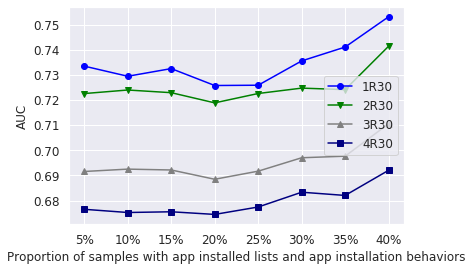

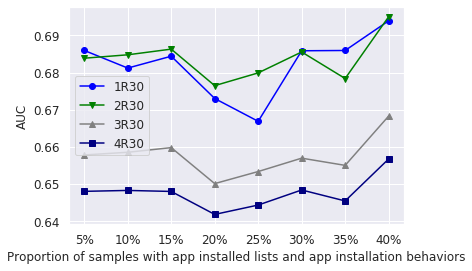

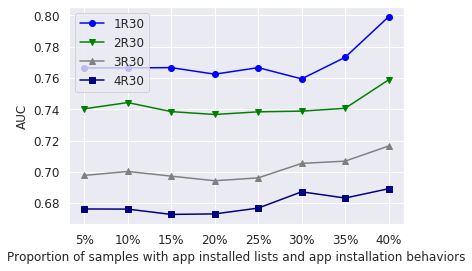

In [14]:
#install_behave_list_set
complete_rate = [5, 10, 15, 20, 25, 30, 35, 40]
all_customers = np.array([
    [ 0.733458,  0.722556 , 0.691586 , 0.676559],
    [ 0.729430,  0.723967 , 0.692527,  0.675286],
    [0.732478 , 0.722905 , 0.692182,  0.675574],
    [0.725755 , 0.718861 , 0.688496 , 0.674525],
    [0.725871 , 0.722579 , 0.691715 , 0.677471],
    [ 0.735530 , 0.724719,  0.697042 , 0.683351],
    [0.741042 , 0.724117,  0.697670,  0.682066],
    [0.753084, 0.741381, 0.710574, 0.692068]
])

new_customers = np.array([
    [0.685973,   0.683886 , 0.657839,   0.648048],
    [ 0.681231 ,  0.684802 ,   0.658567,   0.648294  ],
    [0.684422 ,  0.686330,   0.659816,   0.648023],
    [0.673039 ,  0.676500 , 0.650134,   0.641839],
    [ 0.666899,   0.679930, 0.653381,   0.644363],
    [0.685887 ,  0.685565, 0.656981,   0.648419],
    [0.685965 ,  0.678420, 0.655041,   0.645466],
    [0.693948, 0.695046, 0.668302, 0.656762]
])

regular_customers = np.array([
    [0.766452,   0.740284,   0.697695,   0.676253 ],
    [0.766456,   0.744278,   0.700236,   0.676163  ],
    [ 0.766605,   0.738493,   0.697228,   0.672771],
    [0.762427,   0.736658,   0.694296 ,  0.673095],
    [ 0.766602 ,  0.738357 ,  0.696139,   0.676818 ],
    [0.759425,   0.738805 ,  0.705383,   0.687229 ],
    [0.773204 ,  0.740614,   0.706832,   0.683237 ],
    [0.799148, 0.758816, 0.716508, 0.689202],
])

draw(complete_rate, all_customers, 'ALL_behave_list_list', 'app installed lists and app installation behaviors')
draw(complete_rate, new_customers, 'NEW_behave_list_list', 'app installed lists and app installation behaviors')
draw(complete_rate, regular_customers, 'REGULAR_behave_list_list', 'app installed lists and app installation behaviors')

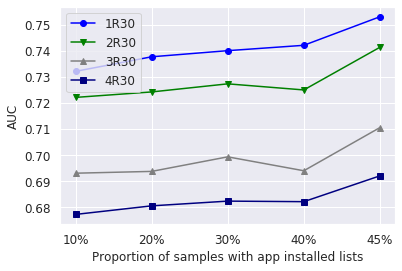

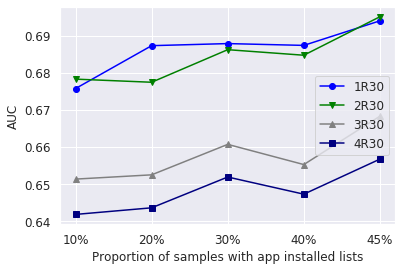

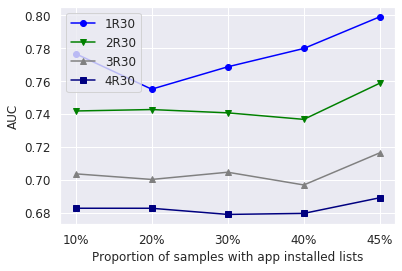

In [18]:
#install_list_set
complete_rate = [10, 20, 30, 40, 45]
all_customers = np.array([
    [0.73214, 0.722154,  0.693085,  0.677281],
    [ 0.737725, 0.724247 , 0.693778,  0.680566],
    [0.740075, 0.727352 ,0.699360,  0.682379],
    [ 0.742131, 0.725014,0.694025,  0.682170],
    [0.753084, 0.741381, 0.710574, 0.692068]
])

new_customers = np.array([
    [0.675739,    0.67827, 0.651393,   0.641896],
    [ 0.687269,   0.677432,  0.652538,   0.643672 ],
    [0.687828,   0.686190,   0.660731,   0.651952],
    [0.687343,   0.684698, 0.655300,   0.647338],
    [0.693948, 0.695046, 0.668302, 0.656762]
])

regular_customers = np.array([
    [ 0.776720,   0.741906,   0.703727,   0.682819  ],
    [0.755140,   0.742776,   0.700312,   0.682809  ],
    [0.768732,   0.740766,   0.704699,   0.679072  ],
    [0.779872,   0.736812,   0.696968,   0.679700  ],
    [0.799148, 0.758816, 0.716508, 0.689202]
])

draw(complete_rate, all_customers, 'ALL_install_list', 'app installed lists')
draw(complete_rate, new_customers, 'NEW_install_list', 'app installed lists')
draw(complete_rate, regular_customers, 'REGULAR_install_list', 'app installed lists')

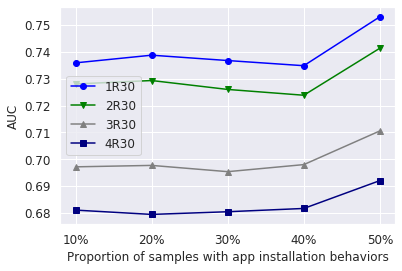

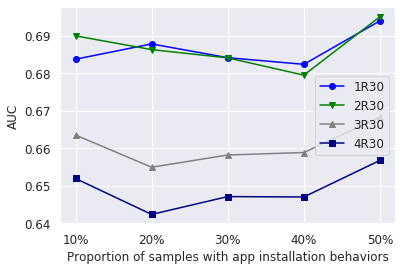

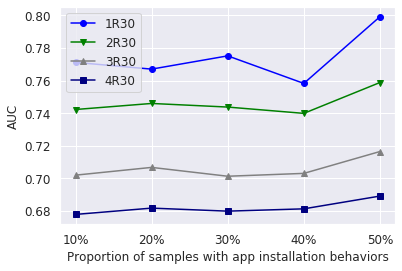

In [15]:
#install_behave_set
complete_rate = [10, 20, 30, 40, 50]
all_customers = np.array([
    [0.735911, 0.728049, 0.697188, 0.681079],
    [0.738768,0.729331,0.697724,0.679471],
    [0.736772, 0.726012, 0.695391, 0.680469],
    [0.734851, 0.723852, 0.698022, 0.681692],
    [0.753084, 0.741381, 0.710574, 0.692068]
])

new_customers = np.array([
    [0.683730, 0.689954, 0.663529, 0.651941],
    [0.687803, 0.686284, 0.654941, 0.642369],
    [0.684129,0.684084,0.658202,0.647121],
    [0.682366, 0.679486, 0.658860, 0.647018],
    [0.693948, 0.695046, 0.668302, 0.656762]
])

regular_customers = np.array([
    [0.771165, 0.742280, 0.702029, 0.677957],
    [0.767036, 0.745989, 0.706785, 0.681823],
    [0.775164,0.743774,0.701364,0.679957],
    [0.758271,0.739912,0.703115,0.681376],
    [0.799148, 0.758816, 0.716508, 0.689202]
])

draw(complete_rate, all_customers, 'ALL_install_behave', 'app installation behaviors')
draw(complete_rate, new_customers, 'NEW_install_behave', 'app installation behaviors')
draw(complete_rate, regular_customers, 'REGULAR_install_behave', 'app installation behaviors')

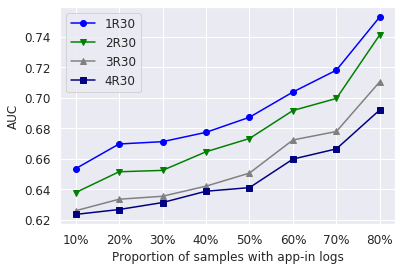

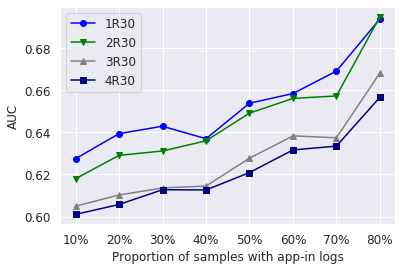

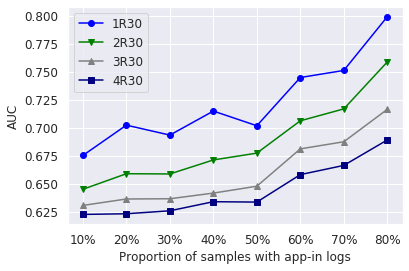

In [17]:
#app in log _set
complete_rate = [10, 20, 30, 40, 50, 60, 70, 80]

all_customers = np.array([
    [ 0.653405,  0.637749,  0.625857,  0.623452],
    [ 0.669636 , 0.651415 , 0.633407,  0.626657],
    [ 0.671152 , 0.652319 , 0.635360,  0.631226],
    [0.677273 , 0.664526 , 0.641977 , 0.638659],
    [0.687167 , 0.673230,  0.650560 , 0.641009],
    [0.703735 , 0.691594,  0.672280 , 0.659739],
    [0.718075 , 0.699508,  0.677832 , 0.666433],
    [0.753084, 0.741381, 0.710574, 0.692068]
])

new_customers = np.array([
    [0.627515 ,  0.617978 , 0.604914  , 0.601008],
    [0.639424 ,  0.629102,  0.610257,   0.605741],
    [0.642967  , 0.631179, 0.613598 ,  0.612753],
    [0.637002 ,  0.636012, 0.614506 ,  0.61264],
    [0.653892,   0.649187, 0.627729  , 0.620903],
    [0.658502 ,  0.656188,  0.638372 ,  0.631688],
    [ 0.669198  , 0.657363,  0.637474 ,  0.633497 ],
    [0.693948, 0.695046, 0.668302, 0.656762]
])

regular_customers = np.array([
    [0.675397 ,  0.645219  , 0.630802 ,  0.622781  ],
    [0.702432 ,  0.659095  , 0.636552 ,  0.623374],
    [0.693552,   0.658884,   0.636758,   0.626013],
    [ 0.714992 ,  0.671378  , 0.641811  , 0.634123 ],
    [ 0.701900,   0.677473 ,  0.647938 ,  0.633786],
    [0.744929,   0.706313 ,  0.681264 ,  0.658289],
    [0.751224 ,  0.716922,   0.687605 ,  0.666498  ],
    [0.799148, 0.758816, 0.716508, 0.689202]
])

draw(complete_rate, all_customers, 'ALL_app-in_log', 'app-in logs')
draw(complete_rate, new_customers, 'NEW_app-in_log', 'app-in logs')
draw(complete_rate, regular_customers, 'REGULAR_app-in_log', 'app-in logs')